In [2]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models, Sequential, callbacks
import tensorflow as tf
from keras.regularizers import l2, l1_l2,l1
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
from sklearn.utils import shuffle
import pandas as pd
from tensorflow.keras.layers import Input
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from scipy.signal import spectrogram, butter, filtfilt
import scipy.io
import seaborn as sns
import matplotlib.pyplot as plt
import math
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
import seaborn as sns
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix
from scipy.stats import skew, kurtosis, entropy, mode
from sklearn.metrics import confusion_matrix
import seaborn as sns
import random
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, LSTM, Flatten, Dense, Dropout, concatenate, Reshape,BatchNormalization
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, confusion_matrix

### Plot History Function

The `plot_history` function is designed for visualizing the training progress and performance of a machine learning model. It accepts a `history` object as input, which typically contains information about the model's training metrics such as loss and accuracy over epochs. The function utilizes Matplotlib to create a graphical representation with two subplots:

1. **Model Loss Plot:**
   - This subplot displays the training and validation loss values over epochs.
   - The x-axis represents the number of epochs, while the y-axis represents the corresponding loss values.
   - Two lines are plotted: one for the training loss and another for the validation loss.
   - The legend indicates which line corresponds to the training data and which to the validation data.
   - This plot helps in analyzing how the model's loss changes during both training and validation phases.

2. **Model Accuracy Plot:**
   - This subplot illustrates the training and validation accuracy of the model across epochs.
   - Similar to the loss plot, the x-axis denotes the epochs, and the y-axis shows the accuracy values.
   - Two curves are plotted: one for training accuracy and another for validation accuracy.
   - The legend specifies which curve represents the training accuracy and which represents the validation accuracy.
   - This plot is beneficial for understanding the model's learning progress and its ability to generalize to unseen data.

By visualizing these metrics, the `plot_history` function facilitates a comprehensive analysis of the model's performance during training, aiding in decision-making regarding model adjustments or tuning.


In [3]:
def plot_history(history):
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Validation'], loc='upper right')

    # Plot training & validation accuracy values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['Train', 'Validation'], loc='lower right')

    plt.tight_layout()
    plt.show()


### Extract General Hospital Lahore EEG Function

## Description
The `extract_ghl_eeg` function reads EEG data from a binary file and reshapes it into a 2D numpy array with dimensions corresponding to the number of channels and samples. This function is designed to handle raw EEG data stored in an 8-bit unsigned integer format.

## Parameters
- `file_path` (str): The path to the binary file containing the EEG data.
- `num_channels` (int): The number of EEG channels in the data.

## Returns
- `eeg_data_reshaped` (numpy.ndarray): A 2D numpy array of shape `(num_channels, num_samples)` containing the reshaped EEG data, where `num_channels` is the number of EEG channels and `num_samples` is the number of samples per channel.

## Example
```python
# Example usage
file_path = 'path/to/eeg/data.bin'
num_channels = 16

eeg_data = extract_ghl_eeg(file_path, num_channels)
print(eeg_data.shape)  # Should print (16, num_samples)


In [ ]:
def extract_ghl_eeg(file_path, num_channels ):
    with open(file_path, 'rb') as f:
        eeg_data = np.fromfile(f, dtype=np.uint8)

    # Extract EEG data
    num_samples = len(eeg_data) // num_channels
    eeg_data_reshaped = eeg_data.reshape((num_samples, num_channels)).T  # Reshape and transpose to match channel x samples
    
    return eeg_data_reshaped

### Plot General Hospitl Lahore EEG Function 

## Description
The `plot_ghl_eeg` function plots EEG data for multiple channels. It allows you to specify the number of samples to plot for each channel, ensuring a clear visualization of the EEG signals across all channels.

## Parameters
- `eeg_data` (numpy.ndarray): A 2D numpy array of shape `(num_channels, num_samples)` containing the EEG data.
- `num_channels` (int): The number of EEG channels.
- `num_samples_to_plot` (int): The number of samples to plot for each channel. This value is capped at the maximum available samples in the data.

## Example
```python
# Example usage
eeg_data = extract_ghl_eeg('path/to/eeg/data.bin', 16)
num_channels = 16
num_samples_to_plot = 1000

plot_ghl_eeg(eeg_data, num_channels, num_samples_to_plot)


In [126]:
def plot_ghl_eeg (eeg_data, num_channels,num_samples_to_plot):
    
    # Ensure the number of samples to plot does not exceed the available data
    num_samples_to_plot = min(num_samples_to_plot, eeg_data_reshaped.shape[1])
    # Plot EEG data for all channels
    plt.figure(figsize=(20, 10))
    for channel in range(num_channels):
        plt.subplot(num_channels, 1, channel + 1)
        plt.plot(eeg_data_reshaped[channel, :num_samples_to_plot])
        plt.title(f'Channel {channel + 1}')  # +1 to match MATLAB 1-based indexing
        plt.xlabel('Sample')
        plt.ylabel('Voltage')

    plt.show() 

### Evaluate General Hospital Lahore EEG Function Documentation

## Description
The `evaluate_ghl_eeg` function evaluates EEG data to predict whether the signal is in an interictal (non-seizure) or preictal (pre-seizure) state. It utilizes pre-trained convolutional neural network (CNN) and hybrid models to generate features and make predictions.

## Parameters
- `eeg_data` (numpy.ndarray): A 2D numpy array containing the EEG data with shape `(num_channels, num_samples)`.

## Returns
- `result` (str): A string indicating the predicted state, either 'preictal' or 'interictal'.

## Example
```python
# Example usage
eeg_data = extract_ghl_eeg('path/to/eeg/data.bin', 16)
result = evaluate_ghl_eeg(eeg_data)
print(f'The predicted state is: {result}')


In [ ]:
def evaluate_ghl_eeg(eeg_data):
    sxx_cnn_model = load_model('/kaggle/input/cnn-model/tensorflow2/convolution_neural_network_model_for_sxx/1/cnn_model_90.h5')
    f, t, Sxx_temp = generate_spectrograms_ghl(eeg_data,256)
    reshaped_array = np.resize(Sxx_temp, (624, 129, 92))
#     plot_ghl_eeg_spectrograms(eeg_data)
    ghl_handcrafted_features = generate_handcrafted_features_ghl(eeg_data_reshaped, 600, 256, sxx_cnn_model)
    
    hybrid_model = load_model('/kaggle/input/epileptic_seizure_prediction_hybrid_model/tensorflow2/hybrid_model_trained_till_40_segments_of_each_subject/1/sxx_lstm_hybrid_model_fully_trained.h5')

    data = np.array(ghl_handcrafted_features).reshape(1, 39, 177)

    prediction = hybrid_model.predict(data)

    interictal = np.count_nonzero( prediction < 0.5 )
    preictal = np.count_nonzero( prediction > 0.5 )

    result = 'precital' if preictal > interictal else 'interictal'
    return result

# Plot General Hospital Lahore EEG Spectrograms Function 

## Description
The `plot_ghl_eeg_spectrograms` function computes and plots the spectrograms of EEG data for multiple channels in a grid of subplots. It uses a specified sampling frequency, segment length, and overlap length for spectrogram computation.

## Parameters
- `eeg_data` (numpy.ndarray): A 2D numpy array containing the EEG data with shape `(num_channels, num_samples)`. The function assumes 16 channels.

## Example
```python
# Example usage
eeg_data = extract_ghl_eeg('path/to/eeg/data.bin', 16)
plot_ghl_eeg_spectrograms(eeg_data)


In [ ]:
def plot_ghl_eeg_spectrograms(eeg_data):
    fs = 256  # Sampling frequency
    nperseg = 256  # Length of each segment
    noverlap = 128 
    spectrograms = []
    num_channels = 16

    # Compute spectrogram for each channel
    for channel in range(num_channels):
        f, t, Sxx = spectrogram(eeg_data[channel, :], fs=fs, nperseg=nperseg, noverlap=noverlap)
        spectrograms.append(Sxx)
        Sxx = np.resize(Sxx, (129, 92))

    # Convert list of spectrograms to a 3D numpy array
    spectrograms = np.array(spectrograms)

    # Check the shape of the spectrogram array
#     print(spectrograms.shape)  # Should be (num_channels, 129, 92)

    # Plot the spectrograms in subplots
    fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(20, 15))
    axes = axes.flatten()
    
    for selected_channel in range(num_channels):
        ax = axes[selected_channel]
        im = ax.pcolormesh(t, f, 10 * np.log10(spectrograms[selected_channel ]), shading='gouraud')
        ax.set_ylabel('Frequency (Hz)')
        ax.set_xlabel('Time (s)')
        ax.set_title(f'Channel {selected_channel + 1}')
        fig.colorbar(im, ax=ax, label='Power/Frequency (dB/Hz)')

    plt.tight_layout()
    plt.show()


### Generate Spectrograms Function

The `generate_spectrograms` function processes EEG data stored in a .mat file to generate spectrograms. Spectrograms are visual representations of the frequencies of a signal over time and are commonly used in signal processing and machine learning applications. Here's an overview of how the function works:

1. **Input Parameters:**
   - `eeg_file_path`: Path to the .mat file containing EEG data.
   - `sequence`: Sequence number specifying which segment of data to process.
   - `segment_type`: Type of segment, either 'interictal' or 'ictal'.

2. **Data Loading:**
   - Loads the specified segment of EEG data from the .mat file.
   - Determines the class label (`class_label`) based on the segment type (0 for 'interictal' and 1 for 'ictal').

3. **Preprocessing:**
   - Extracts data length in seconds (`data_length_sec`) and sampling frequency (`sampling_frequency`) from the loaded data.
   - Defines parameters for spectrogram generation, including window size, overlap, and window size in samples.

4. **Spectrogram Generation:**
   - Iterates over channels in the EEG data.
   - Divides the data into windows with 50% overlap and computes Short-Time Fourier Transform (STFT) spectrograms using the `spectrogram` function.
   - Normalizes the spectrograms using a `StandardScaler` to standardize the data.

5. **Output:**
   - Returns a list of spectrograms (`all_spectrograms`), organized by channels and time windows, ready for further analysis or input to machine learning models.

This function enables the extraction of informative features from EEG data for tasks such as seizure prediction or brain signal analysis.


In [4]:
def generate_spectrograms(eeg_file_path, sequence, segment_type):
    loaded_data = scipy.io.loadmat(eeg_file_path)[segment_type + '_segment_' + str(sequence)]
    eeg_data = loaded_data['data'][0, 0]
    
    class_label = 0 if segment_type == 'interictal' else 1
    
    data_length_sec = loaded_data['data_length_sec'][0, 0]
    sampling_frequency = loaded_data['sampling_frequency'][0, 0][0][0]
    
    window_size = 30
    overlap = 0.5
    window_size_samples = int(window_size * sampling_frequency)
    overlap_samples = int(window_size_samples * overlap)
    
    all_spectrograms = []

    # Iterate over channels
    for channel_data in eeg_data:
        start_time = 0
        spectrograms_channel = []

        # Iterate over windows with 50% overlap
        while start_time + window_size <= data_length_sec:
            end_time = start_time + window_size

            start_sample = int(start_time * sampling_frequency)
            end_sample = int(end_time * sampling_frequency)

            window_data = channel_data[start_sample:end_sample]
            
            # Compute Short-Time Fourier Transform (STFT)
            f, t, Sxx = spectrogram(window_data, fs=sampling_frequency, nperseg=256, noverlap=128)
            
            # normalizing spectrograms
            scaler = StandardScaler()
            Sxx = scaler.fit_transform(Sxx) 
            
            spectrograms_channel.append(Sxx)
            
            start_time += overlap * window_size
        # Append the lists for this channel to the overall arrays
        all_spectrograms.append(spectrograms_channel)
        
        del spectrograms_channel
        
    return all_spectrograms

### Compute Spectrogram Function

The `compute_spectrogram` function is designed to generate spectrograms from EEG data for a specified range of segments and for multiple dogs within a given directory. Here's how the function works:

1. **Input Parameters:**
   - `parent_directory`: The main directory containing subdirectories for each dog's data.
   - `available_dogs`: A list of dog identifiers for which spectrograms will be computed.
   - `segment_type`: The type of segment to process, such as 'interictal' or 'ictal'.
   - `start`: The starting segment number.
   - `end`: The ending segment number.

2. **Spectrogram Computation:**
   - Initializes an empty list `all_spectrograms` to store the computed spectrograms.
   - Iterates through each dog in the `available_dogs` list.
   - Constructs the path to the dog's data directory using `parent_directory` and the dog's identifier.
   - Initializes an empty list `segment_spectrograms` to store spectrograms for each segment.
   - Iterates through the specified range of segments from `start` to `end`.
   - Checks if the segment file exists and, if so, generates spectrograms using the `generate_spectrograms` function.
   - Appends the generated spectrograms for each segment to `segment_spectrograms`.
   - Appends `segment_spectrograms` to `all_spectrograms` for the current dog.
   - Clears `segment_spectrograms` from memory using `del` after each dog's processing.

3. **Array Conversion and Memory Management:**
   - Converts `all_spectrograms` into a NumPy array `all_Sxx`.
   - Clears `all_spectrograms` from memory using `del` to free up memory.

4. **Output:**
   - Returns `all_Sxx`, a NumPy array containing spectrograms for all specified segments and dogs.

This function facilitates efficient computation and organization of spectrogram data for further analysis or machine learning tasks.


In [5]:
def compute_spectrogram (parent_directory,available_dogs, segment_type,start, end):
    
    all_spectrograms = [] 
    for i in range(len(available_dogs)):
        dog_path = f'{parent_directory}/Dog_{available_dogs[i]}/Dog_{available_dogs[i]}'
        
        segment_spectrograms = []
        
        for j in range(start, end):
            # load segment
            segment_path = f'{dog_path}/Dog_{available_dogs[i]}_{segment_type}_segment_{str(j).zfill(4)}.mat'
            if os.path.exists(segment_path):
                segment_spectrograms.append(generate_spectrograms(segment_path,j, segment_type))
        
        all_spectrograms.append(segment_spectrograms)
        
        del segment_spectrograms
        
    all_Sxx = np.array(all_spectrograms)
    
    # to free memory
    del all_spectrograms
    
    return all_Sxx


In [15]:

def generate_handcrafted_features_ghl(eeg_data, data_length_sec, sampling_frequency, sxx_cnn_model):
    # Calculate window size and overlap in samples
    window_size = 30
    overlap = 0.5
    window_size_samples = int(window_size * sampling_frequency)
    overlap_samples = int(window_size_samples * overlap)
    
    # Initialize data dictionary
    data_dic = {'start': []}
    
    num_channels = eeg_data.shape[0]
    
    for i in range(num_channels):
        data_dic[f'mean_{i}'] = []
        data_dic[f'median_{i}'] = []
        data_dic[f'kurtosis_{i}'] = []
        data_dic[f'skewness_{i}'] = []
        data_dic[f'variance_{i}'] = []
        data_dic[f'std_{i}'] = []
        data_dic[f'rms_{i}'] = []
        data_dic[f'zcr_{i}'] = []
        data_dic[f'envelope_{i}'] = []
        data_dic[f'power_{i}'] = []
        data_dic[f'sxx_value_{i}'] = []
    
    # Generate spectrograms
    f, t, Sxx_temp  = generate_spectrograms_ghl(eeg_data, sampling_frequency)
    sxx = np.resize(Sxx_temp, (624, 129, 92))
    prediction = sxx_cnn_model.predict(sxx)
    prediction = prediction.reshape(16, 39)
    
    start_time = 0
    count = 0
    while start_time + window_size <= data_length_sec:
        end_time = start_time + window_size

        start_sample = int(start_time * sampling_frequency)
        end_sample = int(end_time * sampling_frequency)

        data_dic['start'].append(start_time)

        for i in range(num_channels):
            channel_data = eeg_data[i]
            window_data = channel_data[start_sample:end_sample]
            
            data_dic[f'mean_{i}'].append(np.mean(window_data))
            data_dic[f'median_{i}'].append(np.median(window_data))
            data_dic[f'kurtosis_{i}'].append(kurtosis(window_data))
            data_dic[f'skewness_{i}'].append(skew(window_data))
            
            data_dic[f'variance_{i}'].append(np.var(window_data))
            data_dic[f'std_{i}'].append(np.std(window_data))
            data_dic[f'power_{i}'].append(np.mean(np.square(np.abs(window_data))))
            data_dic[f'rms_{i}'].append(np.sqrt(np.mean(window_data**2)))
            data_dic[f'zcr_{i}'].append(np.mean(np.abs(np.diff(np.sign(window_data)))))
            data_dic[f'envelope_{i}'].append(np.abs(np.max(window_data) - np.min(window_data)))
            
            data_dic[f'sxx_value_{i}'].append(prediction[i][count])
        
        count += 1
            

            
        start_time += overlap * window_size
    
    return pd.DataFrame(data_dic, dtype='float64')


In [73]:
def generate_spectrograms_ghl(eeg_data, sampling_frequency):
  
    channels, samples = eeg_data.shape
    window_length = sampling_frequency * 30  # 30 seconds window
    overlap_length = int(0.5 * window_length)  # 0.5% overlap

    # Compute the spectrogram for the first channel to get the shape
    f, t, Sxx_temp = spectrogram(eeg_data_reshaped[0, :], sampling_frequency, nperseg=window_length, noverlap=overlap_length)
    
    # Initialize an array to hold the spectrograms
    Sxx = np.zeros((channels, len(f), len(t)))

    for i in range(channels):
        _, _, Sxx[i] = spectrogram(eeg_data_reshaped[i, :], sampling_frequency, nperseg=window_length, noverlap=overlap_length)

    return f, t, Sxx

In [95]:
def plot_spectrograms(Sxx):
    fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(20, 15))
    axes = axes.flatten()
    
    num_channels = Sxx.shape[0]
    num_frequencies = Sxx.shape[1]
    num_time_points = Sxx.shape[2]

    # Create frequency and time arrays
    f = np.linspace(0, 128, num_frequencies)  # Adjust according to actual frequency range
    t = np.linspace(0, 30, num_time_points)  # Adjust according to actual time duration

    for selected_channel in range(num_channels):
        ax = axes[selected_channel]
        im = ax.pcolormesh(t, f, 10 * np.log10(Sxx[selected_channel]), shading='gouraud')
        ax.set_ylabel('Frequency (Hz)')
        ax.set_xlabel('Time (s)')
        ax.set_title(f'Channel {selected_channel + 1}')
        fig.colorbar(im, ax=ax, label='Power/Frequency (dB/Hz)')

    plt.tight_layout()
    plt.show()

# Exploratory Data Analysis

### Spectrograms for Convolution Neural Network

# iEEG Spectrograms

(16, 129, 1872)


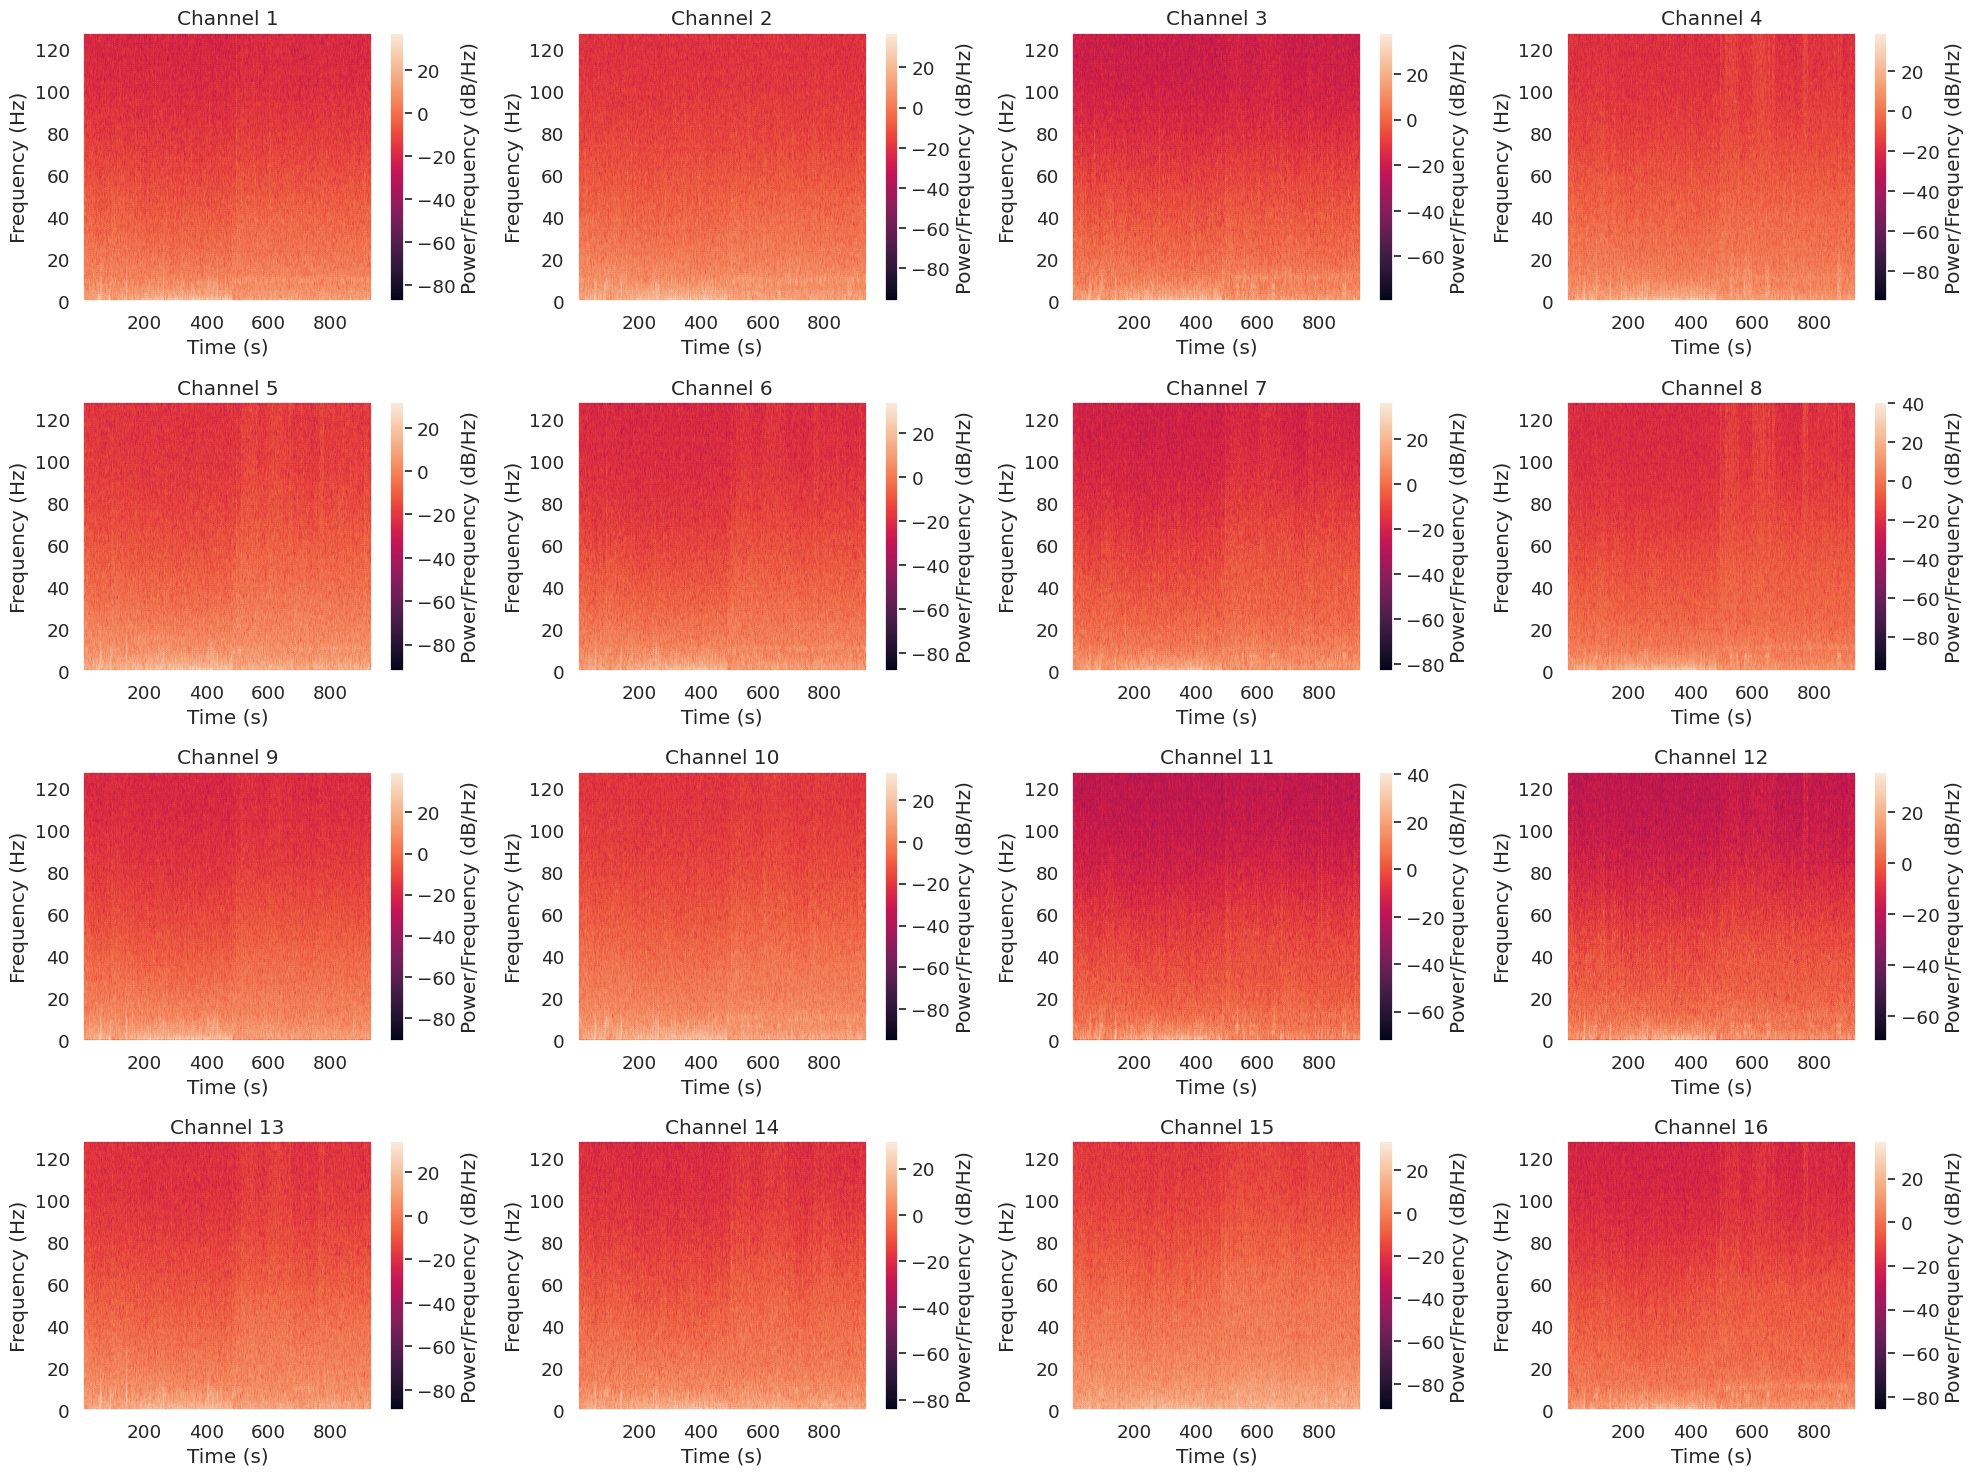

In [97]:
# original segments count for each dog = [42, 72, 97]
eeg_file_path = '/kaggle/input/seizure-prediction/Dog_2/Dog_2/Dog_2_interictal_segment_0001.mat'
segment_type = 'interictal'
sequence = 1
interictal_sample_data  = scipy.io.loadmat(eeg_file_path)[segment_type + '_segment_' + str(sequence)]
eeg_data = interictal_sample_data['data'][0, 0]
plot_ghl_eeg_spectrograms(eeg_data)

# General Hospital Lahore EEG Spectrograms

(16, 129, 1234)


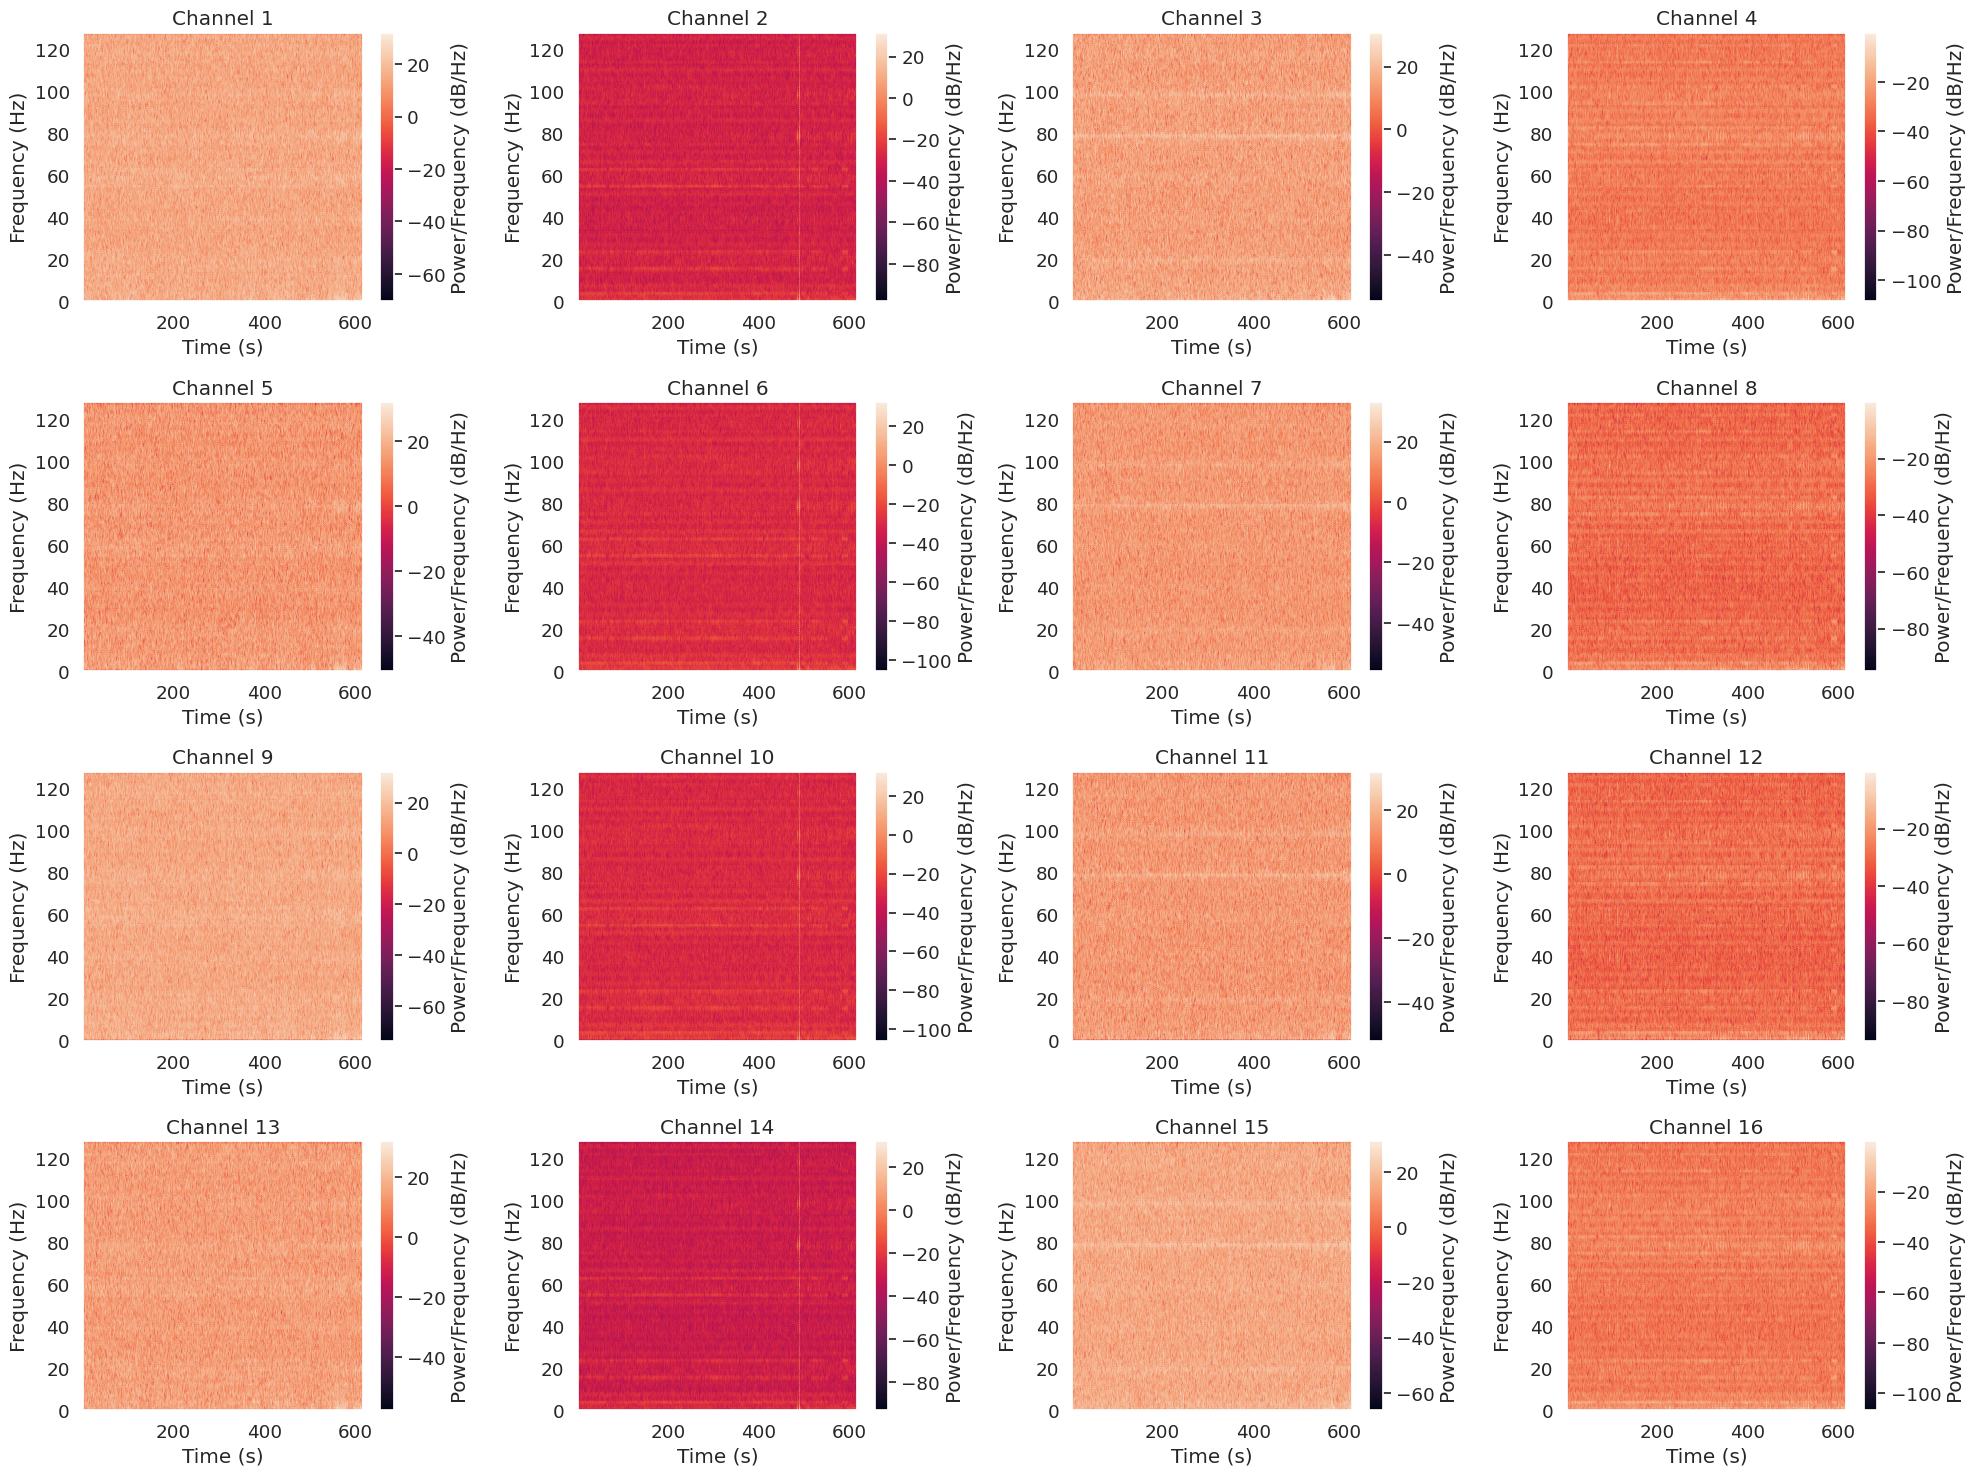

In [130]:
# original segments count for each dog = [42, 72, 97]
file_path = '/kaggle/input/pakistan-institute-neuroscience-neurology-eeg-data/NDC /0000001.eeg'
ghl_eeg = extract_ghl_eeg(file_path, num_channels = 16)
plot_ghl_eeg_spectrograms(ghl_eeg)

# Interictal iEEG 

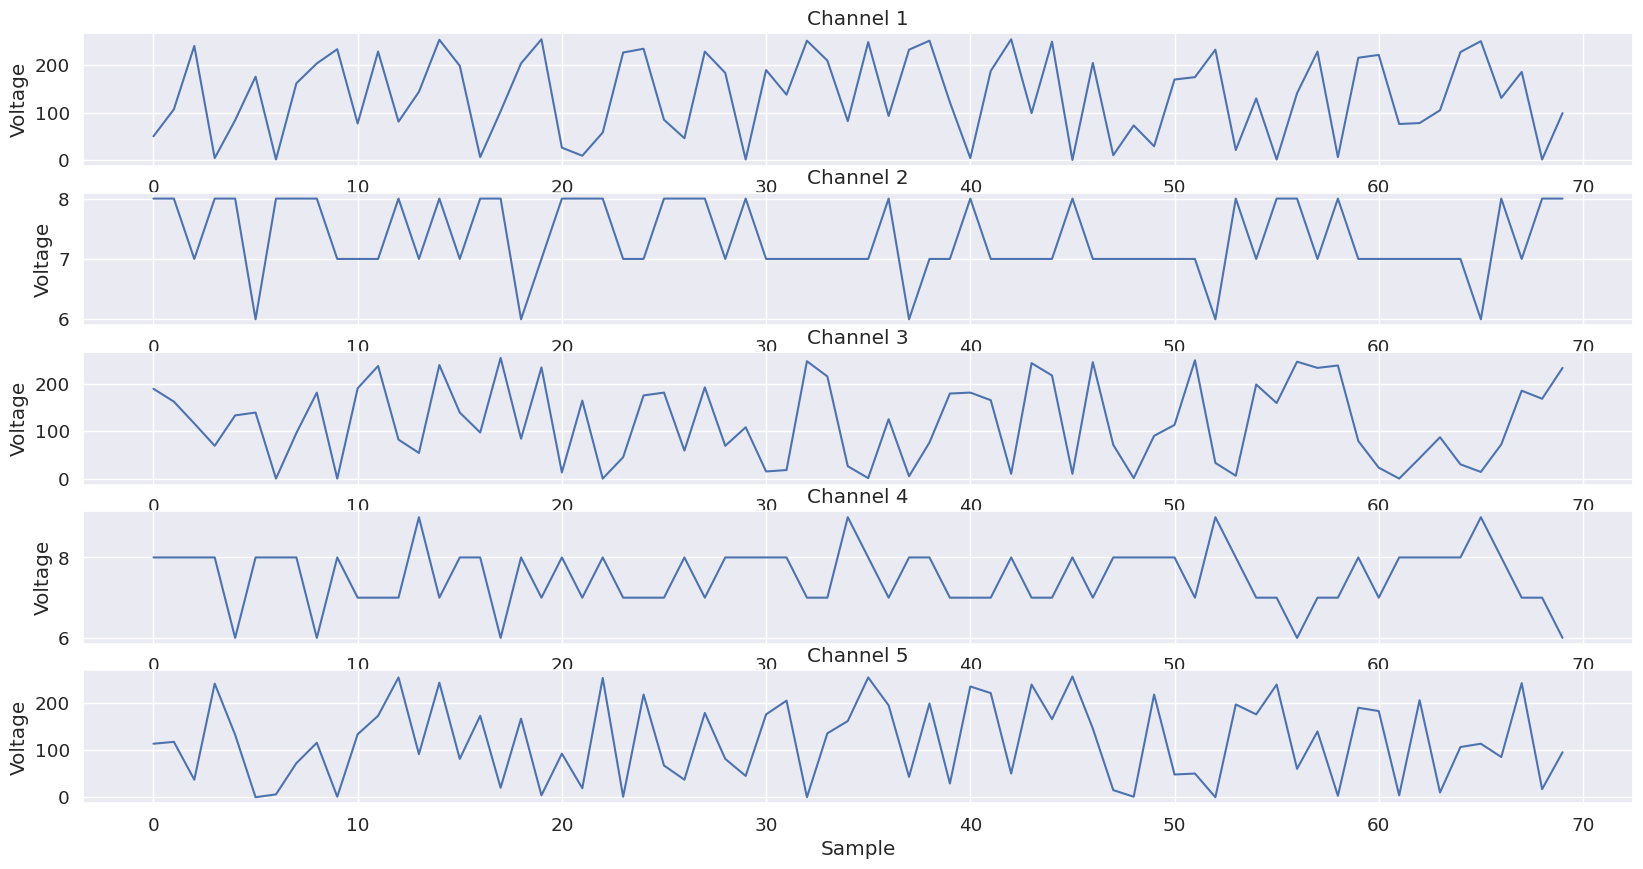

In [137]:
eeg_file_path = '/kaggle/input/seizure-prediction/Dog_2/Dog_2/Dog_2_interictal_segment_0001.mat'
segment_type = 'interictal'
sequence = 1
interictal_sample_data = scipy.io.loadmat(eeg_file_path)[segment_type + '_segment_' + str(sequence)]
interictal_eeg_data = interictal_sample_data['data'][0, 0]
plot_ghl_eeg(interictal_eeg_data, num_channels = 5, num_samples_to_plot = 70)

# Preictal iEEG

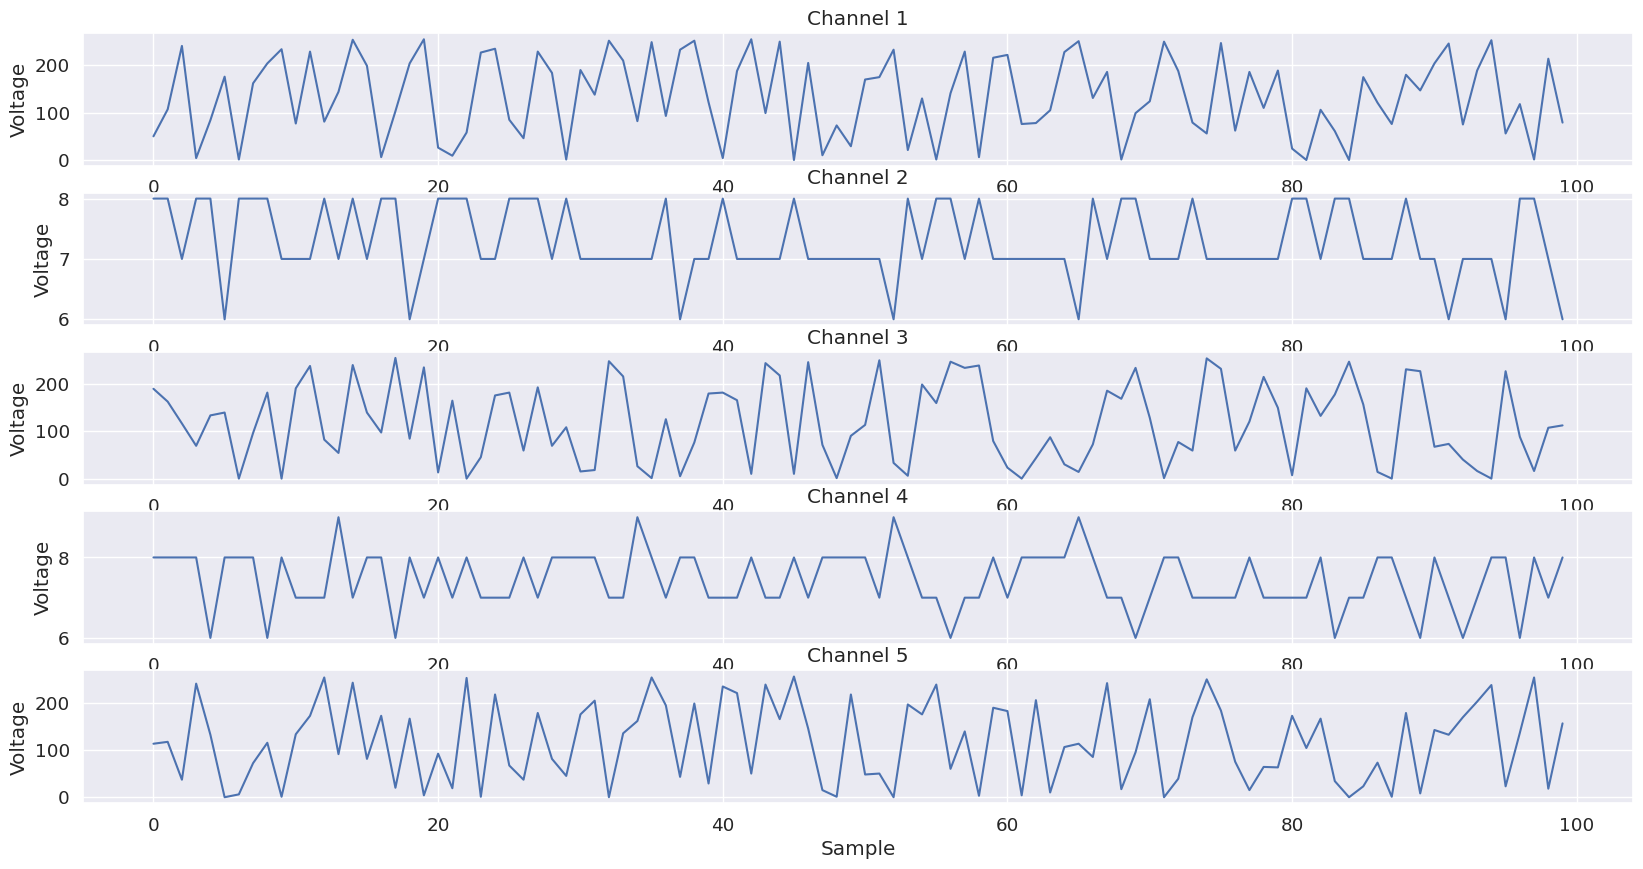

In [138]:
eeg_file_path = '/kaggle/input/seizure-prediction/Dog_2/Dog_2/Dog_2_preictal_segment_0001.mat'
segment_type = 'preictal'
sequence = 1
preictal_sample_data = scipy.io.loadmat(eeg_file_path)[segment_type + '_segment_' + str(sequence)]
preictal_eeg_data = preictal_sample_data['data'][0, 0]
plot_ghl_eeg(preictal_eeg_data, num_channels = 5, num_samples_to_plot = 100)

# iEEG Handcrafted Features

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


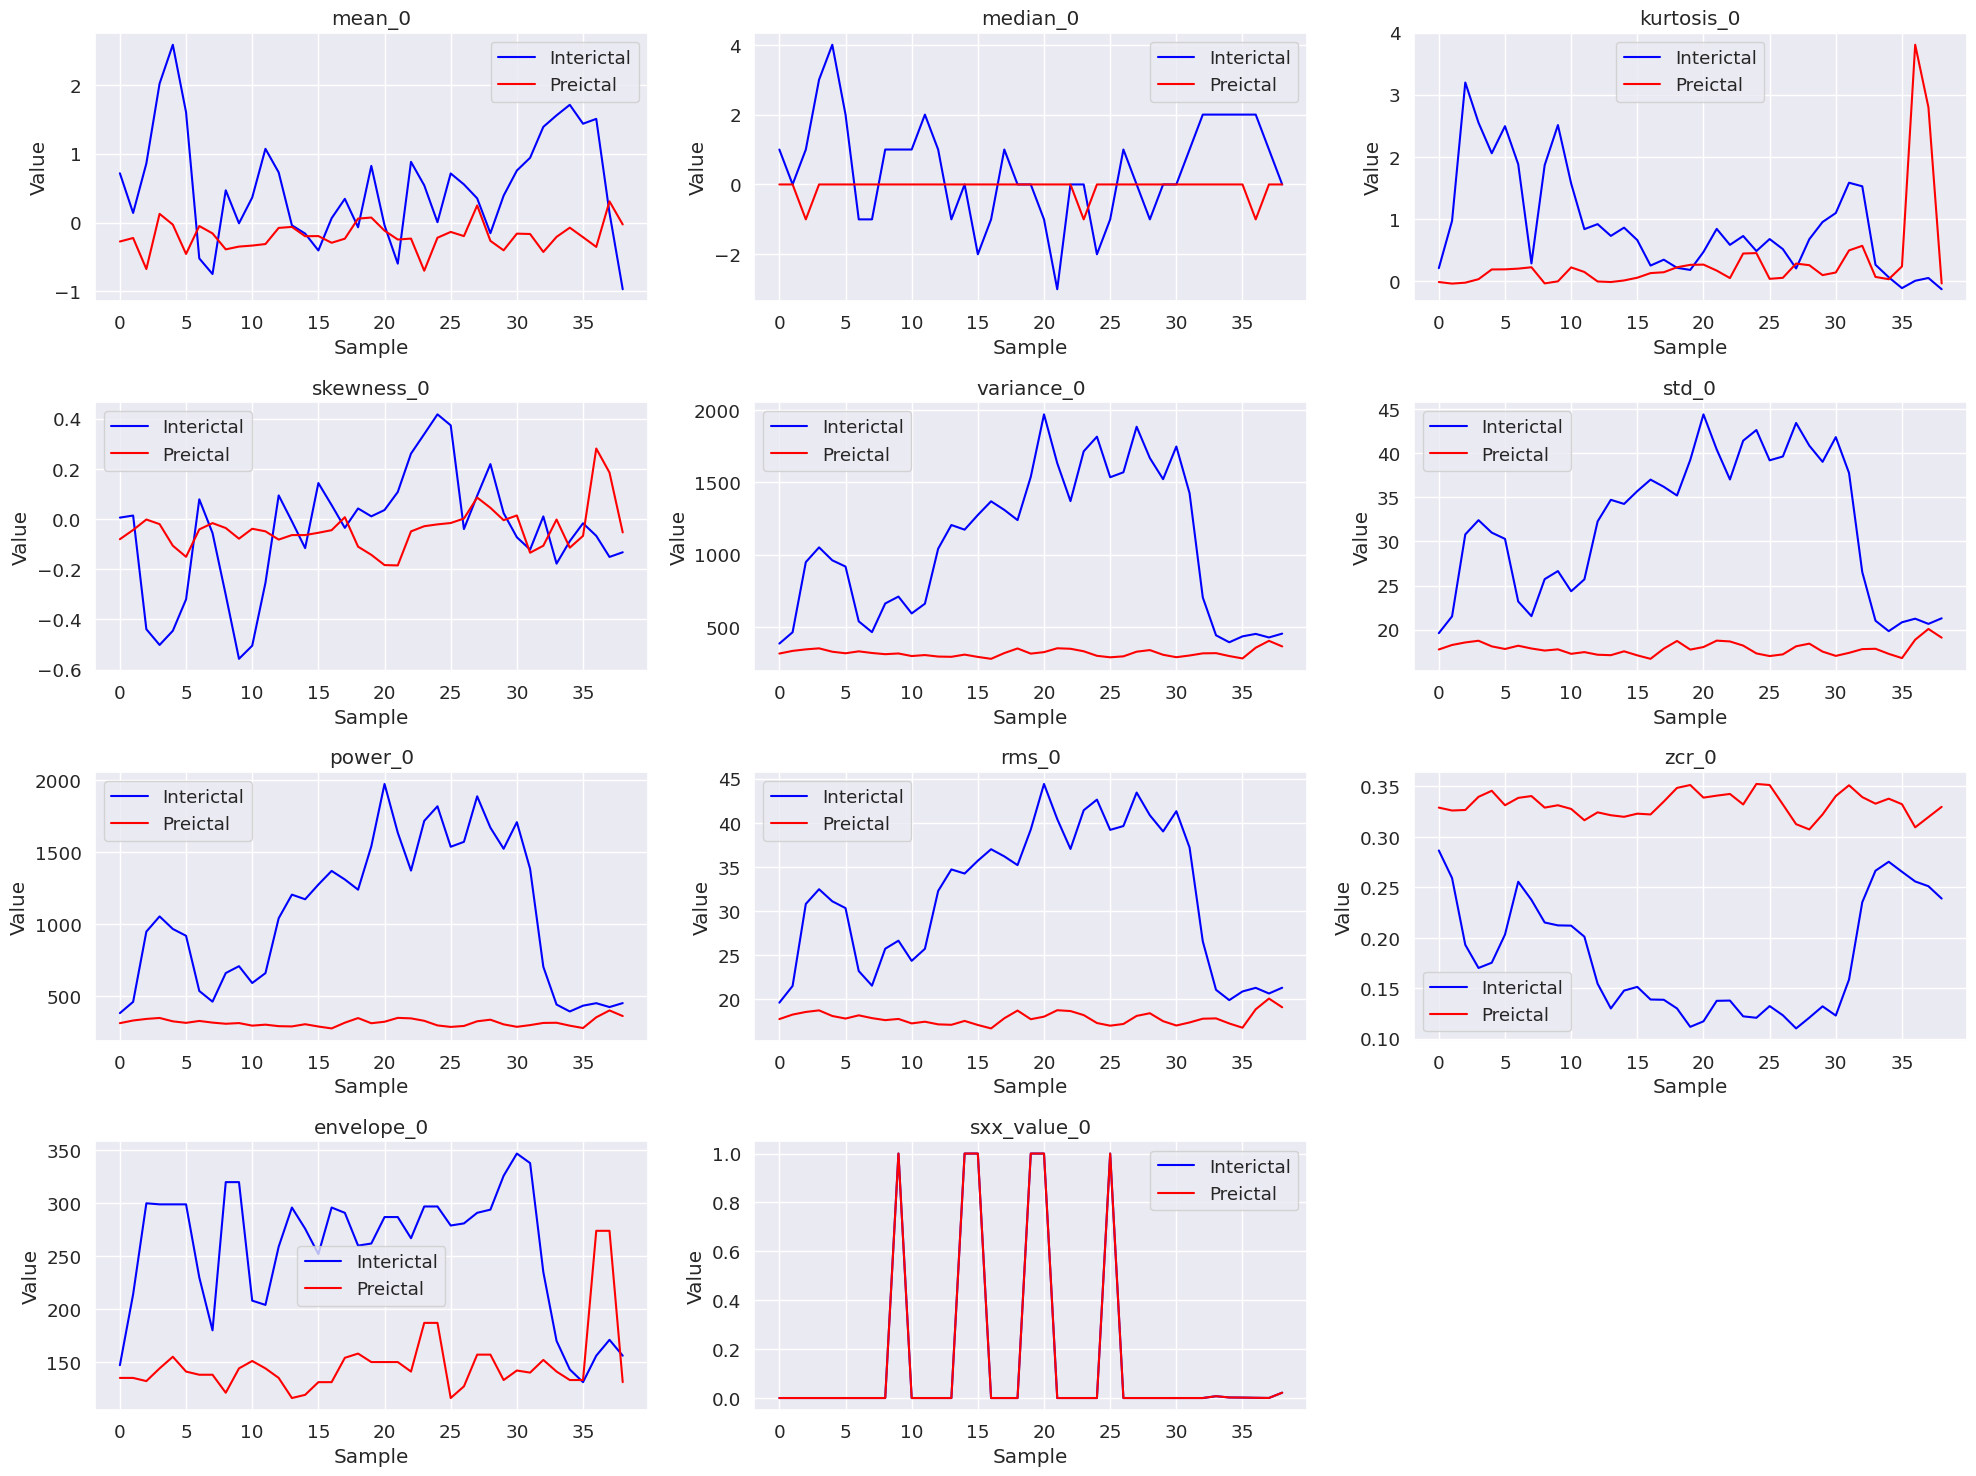

In [122]:

# Assuming generate_handcrafted_features_ghl is defined somewhere else in your code

def plot_features(interictal_features, preictal_features, feature_names):
    num_features = len(feature_names)
    plt.figure(figsize=(20, 15))
    
    for i, feature_name in enumerate(feature_names):
        plt.subplot(4, 3, i + 1)
        plt.plot(interictal_features[feature_name], label='Interictal', color='blue')
        plt.plot(preictal_features[feature_name], label='Preictal', color='red')
        plt.title(feature_name)
        plt.xlabel('Sample')
        plt.ylabel('Value')
        plt.legend()

    plt.tight_layout()
    plt.show()

# Load interictal data
eeg_file_path = '/kaggle/input/seizure-prediction/Dog_2/Dog_2/Dog_2_interictal_segment_0001.mat'
segment_type = 'interictal'
sequence = 1
interictal_sample_data = scipy.io.loadmat(eeg_file_path)[segment_type + '_segment_' + str(sequence)]
interictal_eeg_data = interictal_sample_data['data'][0, 0]

# Load CNN model and extract interictal features
sxx_cnn_model = load_model('/kaggle/input/cnn-model/tensorflow2/convolution_neural_network_model_for_sxx/1/cnn_model_90.h5')
interictal_handcrafted_features = generate_handcrafted_features_ghl(interictal_eeg_data, 600, 256, sxx_cnn_model)

# Load preictal data
eeg_file_path = '/kaggle/input/seizure-prediction/Dog_2/Dog_2/Dog_2_preictal_segment_0001.mat'
segment_type = 'preictal'
sequence = 1
preictal_sample_data = scipy.io.loadmat(eeg_file_path)[segment_type + '_segment_' + str(sequence)]
preictal_eeg_data = preictal_sample_data['data'][0, 0]

# Extract preictal features
preictal_handcrafted_features = generate_handcrafted_features_ghl(preictal_eeg_data, 600, 256, sxx_cnn_model)

# Define feature names
feature_names = ['mean_0', 'median_0', 'kurtosis_0', 'skewness_0', 'variance_0', 
                 'std_0', 'power_0', 'rms_0', 'zcr_0', 'envelope_0', 'sxx_value_0']

# Plot features
plot_features(interictal_handcrafted_features, preictal_handcrafted_features, feature_names)


# General Hospital Lahore Preictal EEG

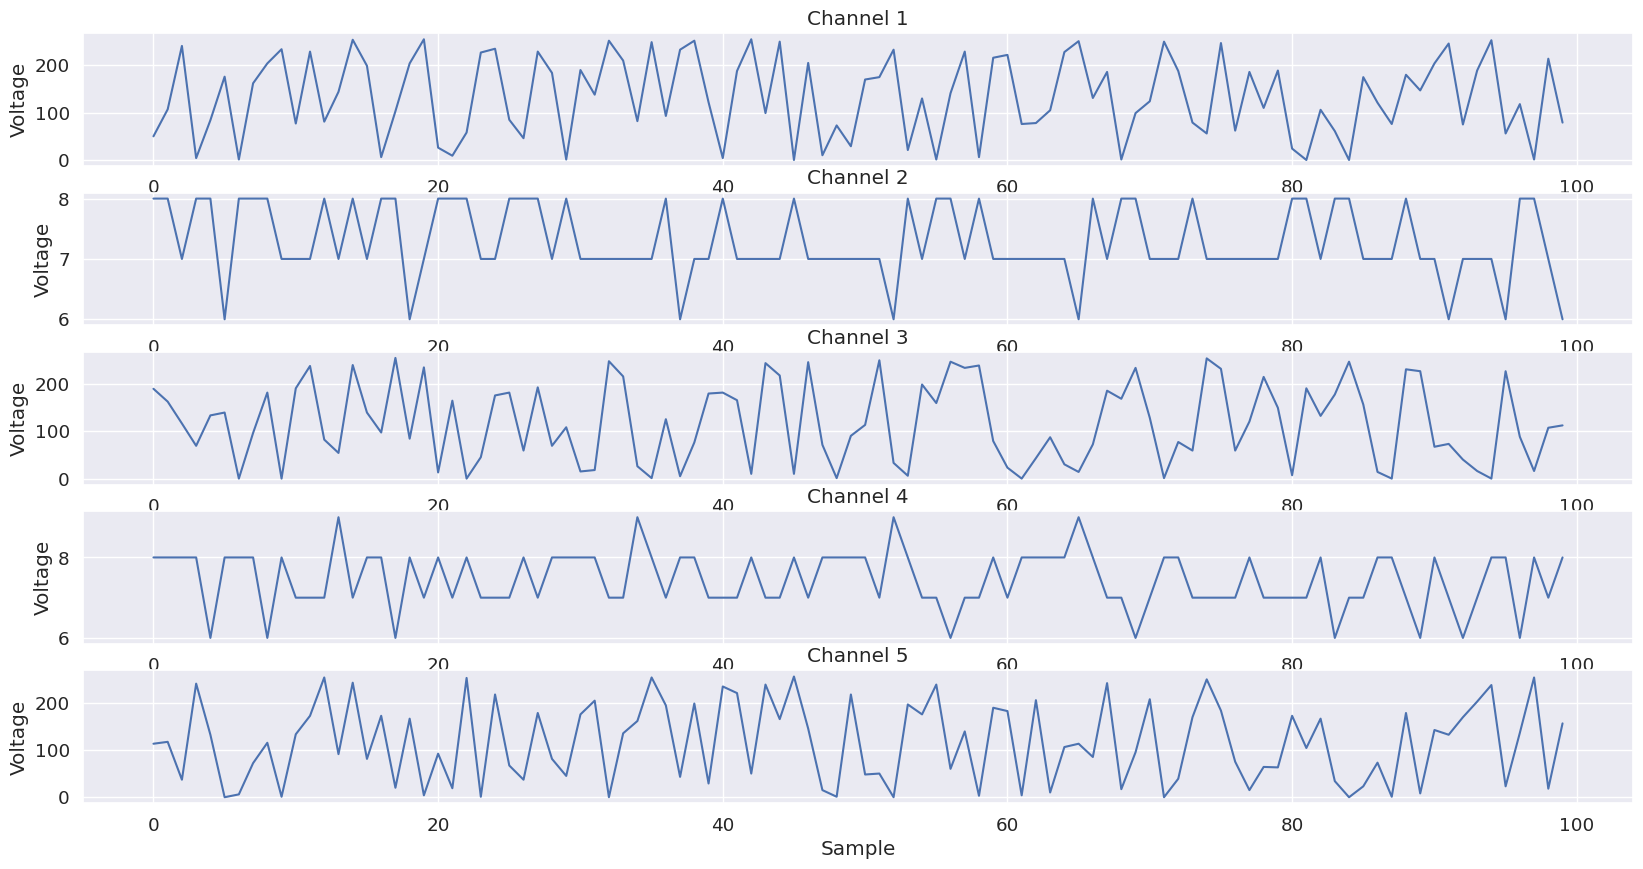

In [128]:
file_path = '/kaggle/input/pakistan-institute-neuroscience-neurology-eeg-data/NDC /0000001.eeg'
ghl_eeg = extract_ghl_eeg(file_path, num_channels = 16)
plot_ghl_eeg(ghl_eeg, num_channels = 5, num_samples_to_plot = 100)

# General Hospital Lahore EEG Handcrafted Features

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


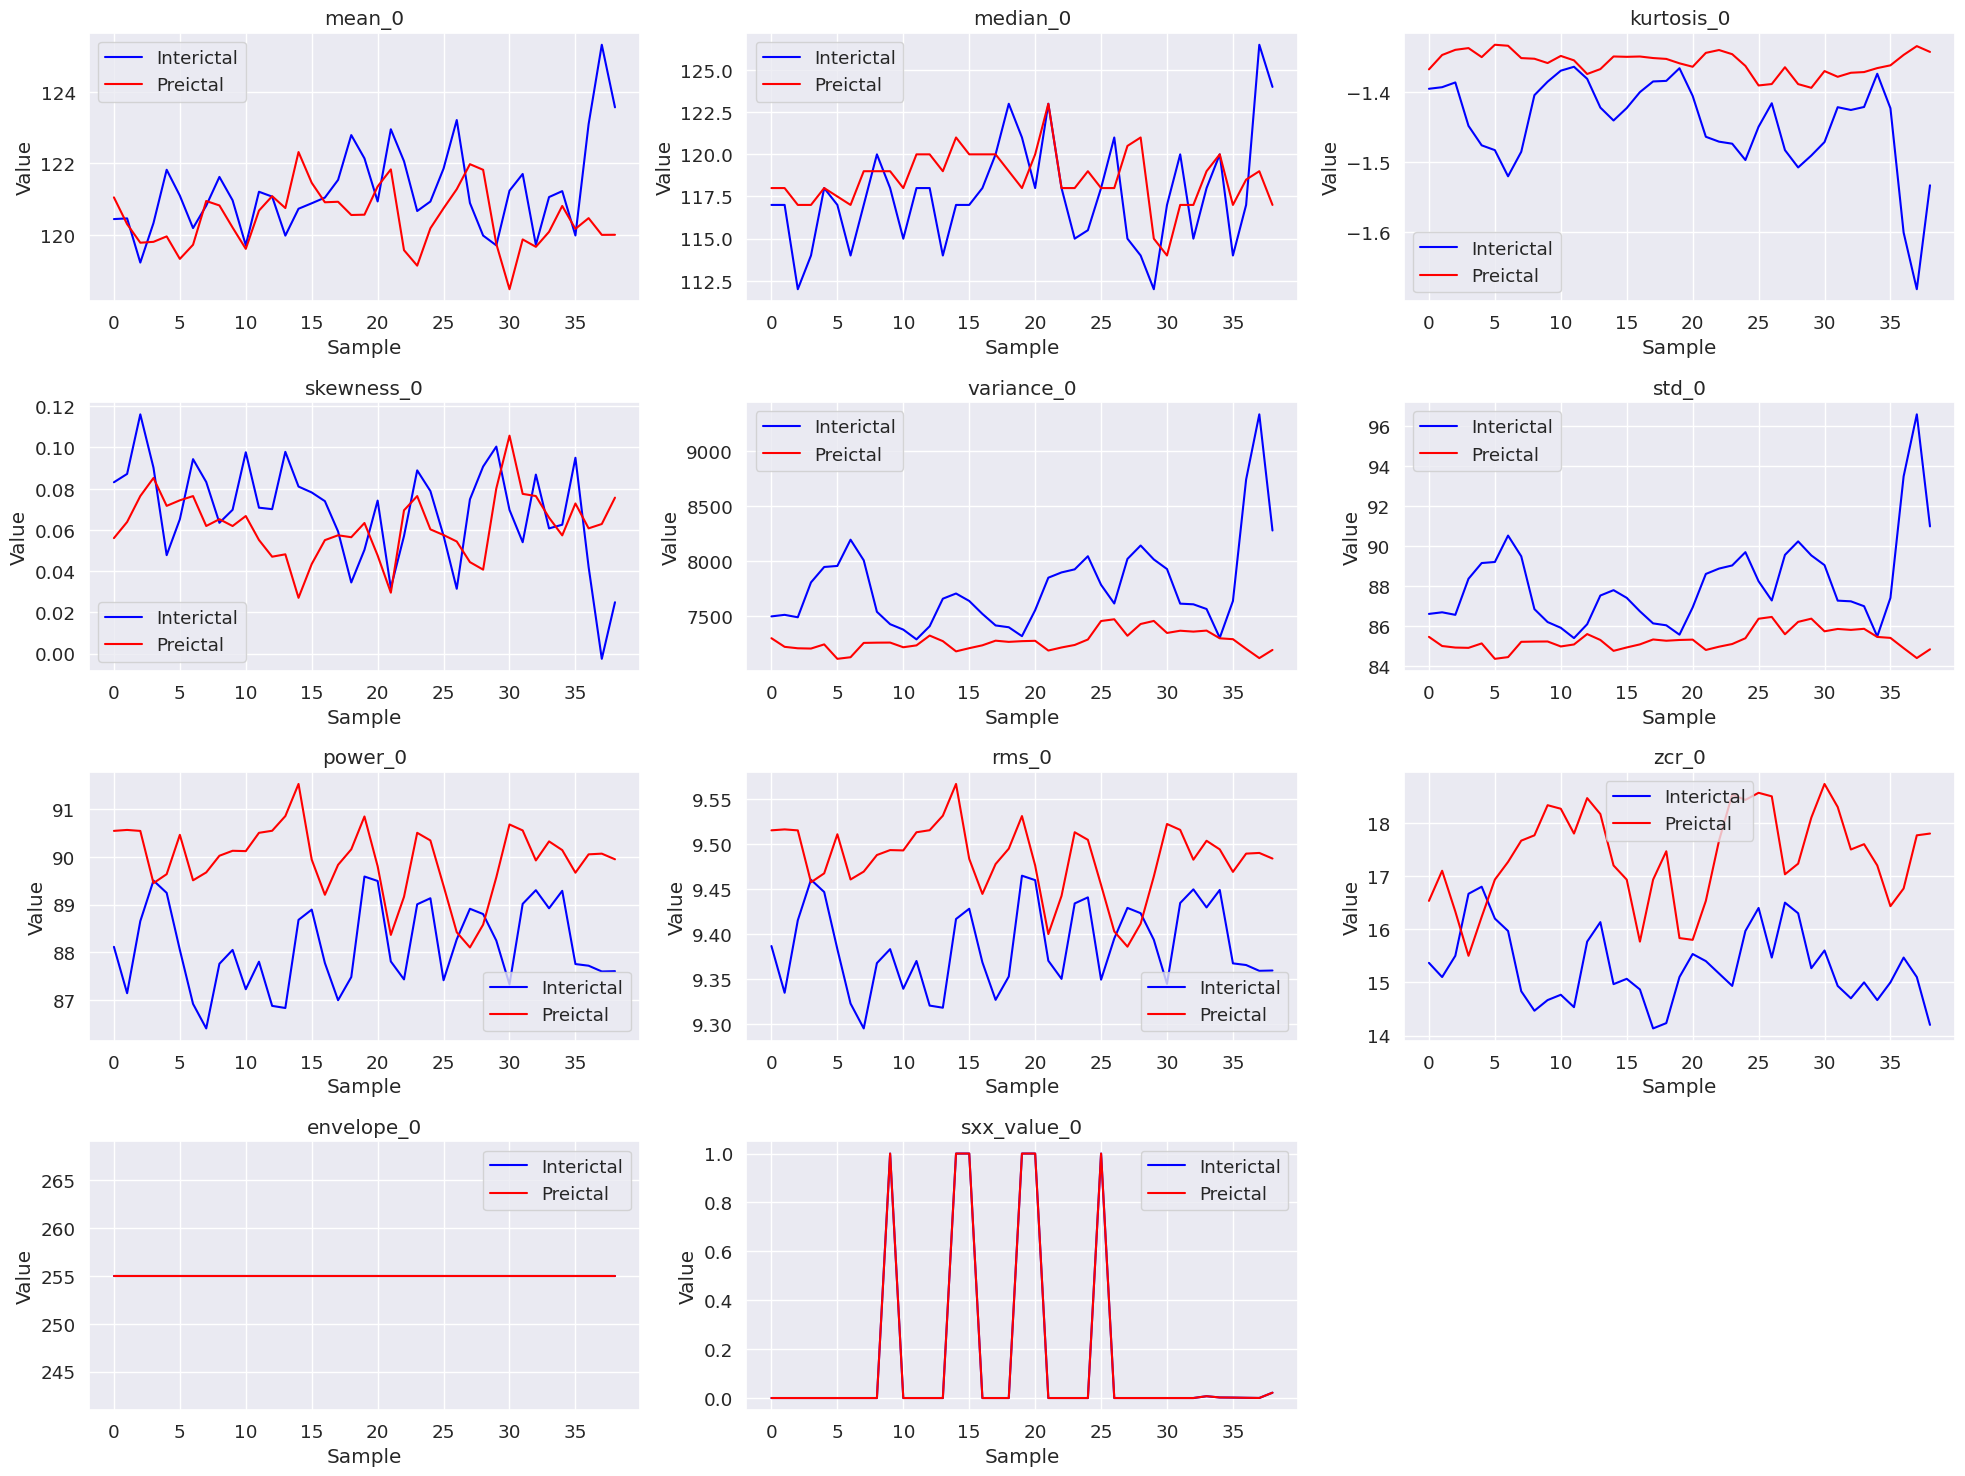

In [140]:

# Assuming generate_handcrafted_features_ghl is defined somewhere else in your code

def plot_features(interictal_features, preictal_features, feature_names):
    num_features = len(feature_names)
    plt.figure(figsize=(20, 15))
    
    for i, feature_name in enumerate(feature_names):
        plt.subplot(4, 3, i + 1)
        plt.plot(interictal_features[feature_name], label='Interictal', color='blue')
        plt.plot(preictal_features[feature_name], label='Preictal', color='red')
        plt.title(feature_name)
        plt.xlabel('Sample')
        plt.ylabel('Value')
        plt.legend()

    plt.tight_layout()
    plt.show()

# Load interictal data
file_path = '/kaggle/input/pakistan-institute-neuroscience-neurology-eeg-data/NDC /0000001.eeg'
interictal_eeg_data = extract_ghl_eeg(file_path, num_channels = 16)

# Load CNN model and extract interictal features
sxx_cnn_model = load_model('/kaggle/input/cnn-model/tensorflow2/convolution_neural_network_model_for_sxx/1/cnn_model_90.h5')
interictal_handcrafted_features = generate_handcrafted_features_ghl(interictal_eeg_data, 600, 256, sxx_cnn_model)

# Load preictal data
file_path = '/kaggle/input/pakistan-institute-neuroscience-neurology-eeg-data/NDC /0000002.eeg'
preictal_eeg_data = extract_ghl_eeg(file_path, num_channels = 16)
# Extract preictal features
preictal_handcrafted_features = generate_handcrafted_features_ghl(preictal_eeg_data, 600, 256, sxx_cnn_model)

# Define feature names
feature_names = ['mean_0', 'median_0', 'kurtosis_0', 'skewness_0', 'variance_0', 
                 'std_0', 'power_0', 'rms_0', 'zcr_0', 'envelope_0', 'sxx_value_0']

# Plot features
plot_features(interictal_handcrafted_features, preictal_handcrafted_features, feature_names)


### Compute Spectrogram Function

The `compute_spectrogram` function generates spectrograms from EEG data for a specified range of segments and for multiple dogs within a given directory.

#### Example Usage:

```python
# original segments count for each dog = [42, 72, 97]
parent_directory = '/kaggle/input/seizure-prediction/'
available_dogs = [2, 3, 4]
start = 1
end = 40

# Compute spectrograms for interictal segments
interictal_spectrograms = compute_spectrogram(parent_directory, available_dogs, 'interictal', start, end)

# Compute spectrograms for preictal segments
preictal_spectrograms = compute_spectrogram(parent_directory, available_dogs, 'preictal', start, end)


In [ ]:
# original segments count for each dog = [42, 72, 97]
parent_directory = '/kaggle/input/seizure-prediction/'
available_dogs = [2,3,4]
start = 70
end = 95
interictal_spectrograms = compute_spectrogram(parent_directory,available_dogs, 'interictal', start, end)
preictal_spectrograms = compute_spectrogram(parent_directory,available_dogs, 'preictal', start,end)


### Create CNN Model Function

The `create_cnn_model` function constructs a Convolutional Neural Network (CNN) model designed to process 2D images with dimensions 129x92 using 1D convolutional layers (`Conv1D`). Here's an overview of the model architecture:

1. **Input Layer:**
   - Input shape is set to (129, 92), representing the dimensions of the 2D image.

2. **Convolutional Layers:**
   - First Conv1D layer with 64 filters, a kernel size of 3, ReLU activation, and L2 kernel regularization.
   - MaxPooling1D layer with a pool size of 2 to downsample the output.
   - Dropout layer with a dropout rate of 0.3 for regularization.

3. **Second Convolutional Layer:**
   - Second Conv1D layer with 128 filters, a kernel size of 3, ReLU activation, and L2 kernel regularization.
   - MaxPooling1D layer with a pool size of 2 to further downsample the output.
   - Dropout layer with a dropout rate of 0.3 for regularization.

4. **Flattening Layer:**
   - Flattens the output from the convolutional layers to prepare for fully connected layers.

5. **Fully Connected Layers:**
   - Dense layer with 128 units and ReLU activation, followed by a dropout layer with a rate of 0.3.
   - Dense layer with 64 units and ReLU activation, followed by another dropout layer with a rate of 0.3.
   - Final Dense layer with 1 unit and sigmoid activation for binary classification tasks.

This architecture is suitable for processing 2D image data using 1D convolutional layers, followed by fully connected layers for feature extraction and classification.


In [ ]:
# create CNN for 2D image of 129,92 with conv1D
def create_cnn_model():
    model = Sequential()
    model.add(Input(shape=(129, 92)))
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu', kernel_regularizer=l2(0.01)))
    model.add(MaxPooling1D(pool_size = 2))
    model.add(Dropout(0.3))     
    
    model.add(Conv1D(filters = 128, kernel_size = 3, activation='relu',kernel_regularizer=l2(0.01)))
    model.add(MaxPooling1D(pool_size = 2))
    model.add(Dropout(0.3))
    
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.3))
    
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.3))
    
    model.add(Dense(1, activation='sigmoid'))
    
    return model

### Data Concatenation and Splitting

To prepare the spectrogram data for training and testing, we perform the following steps:

1. **Concatenation of Data:**
   - Concatenate the 'interictal_spectrograms' and 'preictal_spectrograms' along the samples axis to form the feature matrix `X`.
   - Create the target vector `y` by concatenating zeros (representing 'interictal' segments) and ones (representing 'preictal' segments).

2. **Data Splitting:**
   - Split the concatenated data (`X`) and target (`y`) into training and testing sets using the `train_test_split` function.
   - Set the test size to 20% of the data and use a random state of 42 for reproducibility.

Here's the code snippet in markdown format:

```python
# Concatenate the data
X = np.concatenate((interictal_spectrograms.reshape(-1, 129, 92), preictal_spectrograms.reshape(-1, 129, 92)))
y = np.concatenate((np.zeros(interictal_spectrograms.reshape(-1, 129, 92).shape[0]), np.ones(preictal_spectrograms.reshape(-1, 129, 92).shape[0])))

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:

# concatenate the data
X = np.concatenate((interictal_spectrograms.reshape(-1, 129, 92),  preictal_spectrograms.reshape(-1, 129, 92)))
y = np.concatenate((np.zeros(interictal_spectrograms.reshape(-1, 129, 92).shape[0]) , np.ones(preictal_spectrograms.reshape(-1, 129, 92).shape[0])))

# split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
del X
del y
del interictal_spectrograms
del preictal_spectrograms

In [ ]:
del X_train 
del X_test 
del y_train 
del y_test

### CNN Model Training

This code snippet performs several tasks related to training and evaluating a convolutional neural network (CNN) model using TensorFlow:

1. **GPU Availability Check:**
   - `device = tf.config.list_physical_devices('GPU')`: Checks if a GPU is available for computation.
   - If a GPU is available:
     - `tf.config.experimental.set_memory_growth(device[0], True)`: Sets GPU memory growth to avoid memory allocation issues.

2. **Model Creation and Compilation:**
   - `cnn_model = create_cnn_model()`: Creates the CNN model using the `create_cnn_model` function.
   - `sxx_cnn_model.compile(...)`: Compiles the model with an Adam optimizer, binary cross-entropy loss, and accuracy metric.

3. **Training Configuration:**
   - `early_stopping`, `lr_scheduler`, and `reduce_lr`: Define callback functions for early stopping, learning rate scheduling, and reducing learning rate on plateau.

4. **Model Training:**
   - `history = sxx_cnn_model.fit(...)`: Trains the model using training data (`X_train`, `y_train`) for 100 epochs with a batch size of 32.
   - `validation_data=(X_test, y_test)`: Uses validation data (`X_test`, `y_test`) for model evaluation during training.
   - Callbacks `[early_stopping, lr_scheduler, reduce_lr]` are applied during training.

5. **Model Evaluation:**
   - `loss, accuracy = sxx_cnn_model.evaluate(X_test, y_test)`: Evaluates the trained model using test data and computes loss and accuracy.

6. **Training History Plotting:**
   - `plot_history(history)`: Plots the training history (loss and accuracy) using the `plot_history` function.

7. **GPU Availability Output:**
   - If a GPU is not available, it prints "No GPU available."

This code segment encapsulates the entire workflow of creating, compiling, training, evaluating, and visualizing the performance of a CNN model for binary classification, handling GPU availability and memory management.


In [ ]:
device = tf.config.list_physical_devices('GPU')
if device:
    print('GPU:', device[0])
    tf.config.experimental.set_memory_growth(device[0], True)
    
    # create the model
#     cnn_model = create_cnn_model()
    
    # incase if we want to train the pre-trained model in increamental training fashion
    cnn_model = load_model('/kaggle/input/cnn-model/tensorflow2/cnn_1_40/2/cnn_model_40_70_segs.h5')

    cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience = 5, restore_best_weights = True)
    lr_scheduler = callbacks.LearningRateScheduler(lambda epoch: 1e-3 * (0.9 ** epoch)) 
    reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor = 0.2, patience = 5, min_lr = 0.001)

    # train the model
    history = cnn_model.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test), batch_size=32,callbacks=[early_stopping, lr_scheduler, reduce_lr])

    # evaluate the model
    loss, accuracy = cnn_model.evaluate(X_test, y_test)
    print(f'Loss: {loss}, Accuracy: {accuracy}')

    # plot the training history
    plot_history(history)
else:
    print("No GPU available.")


In [ ]:
cnn_model.save('cnn_model_90.h5')

### Evaluate CNN Model Function

The `evaluate_cnn_model` function is designed to evaluate a given CNN model's performance on EEG segments for a specific dog and segment type. Here's an overview of how the function works:

1. **Input Parameters:**
   - `model`: The CNN model to be evaluated.
   - `total_segments`: The total number of segments to evaluate for the specified dog and segment type.
   - `segment_type`: The type of segment to evaluate, such as 'interictal' or 'preictal'.
   - `dog_number`: The identifier of the dog for which the segments are evaluated.

2. **Segment Evaluation Loop:**
   - Initializes counters `i` (interictal segments count) and `p` (preictal segments count) to keep track of segment predictions.
   - Iterates through each segment number from 1 to `total_segments`.
   - Constructs the file path for the segment using the provided parameters.
   - Generates spectrograms (`sxx`) for the segment using the `generate_spectrograms` function and reshapes them.
   - Uses the CNN model (`model`) to predict the class probabilities for the segment.
   - Counts the number of predictions indicating 'interictal' and 'preictal' classes using NumPy's `count_nonzero`.
   - Determines the final prediction ('interictal' or 'preictal') based on the majority of predictions.

3. **Result Calculation:**
   - Updates the counters `i` and `p` based on the final prediction for each segment.
   - Returns the counts of 'interictal' (i) and 'preictal' (p) segments.

This function evaluates the CNN model's predictions for multiple EEG segments and provides the counts of predicted 'interictal' and 'preictal' segments for further analysis or reporting.


In [ ]:
def evaluate_cnn_model(model, total_segments,segment_type, dog_number):
    i = 0
    p = 0
    
    for segment_number in range(1,total_segments):
        segment_path = f'/kaggle/input/seizure-prediction/Dog_{dog_number}/Dog_{dog_number}/Dog_{dog_number}_{segment_type}_segment_{segment_number:04d}.mat'

        sxx = generate_spectrograms(segment_path,segment_number, segment_type)
        sxx = np.array(sxx).reshape(-1,129,92)
        prediction = sxx_cnn_model.predict(sxx)

        interictal = np.count_nonzero( prediction < 0.5 )
        preictal = np.count_nonzero( prediction > 0.5 )

        result = 'precital' if preictal > interictal else 'interictal'

        if result == 'precital':
            p += 1
        else:
            i += 1
    
    return i, p


### Create Confusion Matrix Function

The `create_confusion_matrix` function is used to generate a confusion matrix based on the true and predicted labels of a binary classification problem. Here's how the function works:

1. **Input Parameters:**
   - `interictal_x`: The count of true 'interictal' samples that were incorrectly predicted as 'preictal'.
   - `preictal_x`: The count of true 'preictal' samples that were incorrectly predicted as 'interictal'.
   - `interictal_y`: The count of true 'interictal' samples that were correctly predicted.
   - `preictal_y`: The count of true 'preictal' samples that were correctly predicted.

2. **Label Preparation:**
   - Creates two lists of labels: `true_labels` containing all true labels (in the order of incorrect 'interictal', incorrect 'preictal', correct 'interictal', and correct 'preictal'), and `predicted_labels` containing all predicted labels (in the order of incorrect 'interictal', incorrect 'preictal', correct 'interictal', and correct 'preictal').

3. **Confusion Matrix Calculation:**
   - Uses the `confusion_matrix` function from scikit-learn to compute the confusion matrix based on `true_labels` and `predicted_labels`.

4. **Visualization:**
   - Plots the confusion matrix using `matplotlib` and `seaborn`, with annotations, color mapping ('Blues' colormap), and labels for both axes.
   - Displays the plot with the title 'Confusion Matrix'.

This function is useful for visually assessing the performance of a binary classification model by comparing true and predicted labels across different classes ('interictal' and 'preictal').


In [6]:
def create_confusion_matrix(interictal_x,preictal_x,interictal_y,preictal_y):

    true_labels = ['interictal'] * (interictal_x + preictal_x) + ['preictal'] * (interictal_y + preictal_y)
    predicted_labels = ['interictal'] * interictal_y + ['preictal'] * preictal_y + ['interictal'] * interictal_x + ['preictal'] * preictal_x

    cm = confusion_matrix(true_labels, predicted_labels)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', xticklabels=['interictal', 'preictal'], yticklabels=['interictal', 'preictal'])
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

### Confusion Matrix Evaluation for CNN Model

This code segment evaluates the performance of a trained CNN model (`sxx_cnn_model`) using confusion matrices for different dogs and segment types.

1. **Preparation and Loading Model:**
   - Loads the trained CNN model from the specified path.

2. **Evaluation for Dog 2:**
   - Tests the model's performance on preictal and interictal labels for Dog 2, which has 42 segments.
   - `evaluate_cnn_model(sxx_cnn_model, 42,'preictal', 2)`: Evaluates preictal segments for Dog 2.
   - `evaluate_cnn_model(sxx_cnn_model, 42,'interictal', 2)`: Evaluates interictal segments for Dog 2.
   - Creates a confusion matrix based on the evaluation results.

3. **Evaluation for Dog 3:**
   - Tests the model's performance on preictal and interictal labels for Dog 3, which has 72 segments.
   - Similar evaluation steps are performed for Dog 3 as for Dog 2.

4. **Evaluation for Dog 4:**
   - Tests the model's performance on preictal and interictal labels for Dog 4, which has 97 segments.
   - Similar evaluation steps are performed for Dog 4 as for Dogs 2 and 3.

5. **Printing and Visualizing Results:**
   - Prints the counts of predicted 'interictal' and 'preictal' segments for each evaluation.
   - Generates and displays confusion matrices using the `create_confusion_matrix` function based on the evaluation results.

These evaluations help understand how well the CNN model performs in distinguishing between 'interictal' and 'preictal' segments for different dogs.


In [ ]:
# original segments count for each dog = [42, 72, 97]

sxx_cnn_model = load_model('/kaggle/input/cnn-model/tensorflow2/convolution_neural_network_model_for_sxx/1/cnn_model_90.h5')

# testing for preictal labels of dog 2
interictal_x , preictal_x = evaluate_cnn_model(sxx_cnn_model, 42,'preictal', 2)
print("Given all preictal: ", "interictal predicted: ", interictal_x, "preictal predicted: ", preictal_x)
interictal_y , preictal_y = evaluate_cnn_model(sxx_cnn_model, 42,'interictal', 2)
print("Given all interictal: ", "interictal predicted: ", interictal_y, "preictal predicted: ", preictal_y)
create_confusion_matrix(interictal_x,preictal_x,interictal_y,preictal_y)


# testing for preictal labels of dog 3
interictal_x , preictal_x = evaluate_cnn_model(sxx_cnn_model, 72,'preictal', 3)
print("Given all preictal: ", "interictal predicted: ", interictal_x, "preictal predicted: ", preictal_x)
interictal_y , preictal_y = evaluate_cnn_model(sxx_cnn_model, 72,'interictal', 3)
print("Given all interictal: ", "interictal predicted: ", interictal_y, "preictal predicted: ", preictal_y)
create_confusion_matrix(interictal_x,preictal_x,interictal_y,preictal_y)

# testing for preictal labels of dog 4
interictal_x , preictal_x = evaluate_cnn_model(sxx_cnn_model, 97,'preictal', 4)
print("Given all preictal: ", "interictal predicted: ", interictal_x, "preictal predicted: ", preictal_x)
interictal_y , preictal_y = evaluate_cnn_model(sxx_cnn_model, 97,'interictal', 4)
print("Given all interictal: ", "interictal predicted: ", interictal_y, "preictal predicted: ", preictal_y)
create_confusion_matrix(interictal_x,preictal_x,interictal_y,preictal_y)


### Generate Handcrafted Features Function

The `generate_handcrafted_features` function is designed to extract handcrafted features from EEG data segments and generate a DataFrame containing these features along with corresponding labels. Here's an overview of how the function works:

1. **Input Parameters:**
   - `eeg_file_path`: The path to the EEG data file.
   - `sequence`: The sequence number of the EEG segment.
   - `segment_type`: The type of EEG segment ('interictal' or 'preictal').

2. **Data Extraction and Preparation:**
   - Loads the EEG data file and extracts necessary information such as data, data length, sampling frequency, and channels.
   - Sets up dictionaries (`data_dic`) to store handcrafted features for each channel.
   - Initializes lists (`labels`) to store segment labels based on `segment_type`.
   - Loads the CNN model (`sxx_cnn_model`) for generating spectrograms and predictions.

3. **Feature Generation Loop:**
   - Generates spectrograms (`sxx`) using the `generate_spectrograms` function and reshapes them.
   - Predicts labels for the spectrograms using `sxx_cnn_model` and reshapes the predictions.
   - Iterates through windows of EEG data with a specified window size and overlap.
   - Computes handcrafted features such as mean, median, kurtosis, skewness, variance, standard deviation, power, RMS, zero-crossing rate, envelope, and spectrogram value for each channel within each window.
   - Appends the computed features and labels to the respective dictionaries and lists.

4. **DataFrame Creation:**
   - Converts the dictionaries (`data_dic`) into a pandas DataFrame for easy handling and analysis.
   - Assigns the appropriate data types (`float64`) to the DataFrame columns.

5. **Label Assignment:**
   - Assigns labels ('0' for 'interictal' and '1' for 'preictal') to the corresponding windows of EEG data.

6. **Output:**
   - Returns the DataFrame containing handcrafted features and labels for the EEG data segments.

This function facilitates the extraction and organization of handcrafted features from EEG data, which can be used for further analysis and machine learning tasks.


In [7]:
def generate_handcrafted_features(eeg_file_path, sequence, segment_type):
    eeg_file = scipy.io.loadmat(eeg_file_path)[segment_type + '_segment_' + str(sequence)]

    eeg_data = eeg_file['data'][0, 0]
    data_length_sec = eeg_file['data_length_sec'][0, 0]
    sampling_frequency = eeg_file['sampling_frequency'][0, 0][0][0]
    channels = eeg_file['channels'][0, 0][0]

    window_size = 30
    overlap = 0.5
    window_size_samples = int(window_size * sampling_frequency)
    overlap_samples = int(window_size_samples * overlap)

    data_dic = {
        'start': [],
    }
    
    sxx_cnn_model = load_model('/kaggle/input/cnn-model/tensorflow2/convolution_neural_network_model_for_sxx/1/cnn_model_90.h5')
    labels = []
    for i in channels:
        channel_name = i[0][-4:]  # Extract the channel name from the array

        data_dic[f'mean_{channel_name}'] = []
        data_dic[f'median_{channel_name}'] = []
        data_dic[f'kurtosis_{channel_name}'] = []
        data_dic[f'skewness_{channel_name}'] = []
        data_dic[f'variance_{channel_name}'] = []
        data_dic[f'std_{channel_name}'] = []
        data_dic[f'rms_{channel_name}'] = []  # Add RMS
        data_dic[f'zcr_{channel_name}'] = []  # Add zero-crossing rate
        data_dic[f'envelope_{channel_name}'] = []  # Add envelope
        data_dic[f'power_{channel_name}'] = []  # Add power
        data_dic[f'sxx_value_{channel_name}'] = []

    
    
    sxx = generate_spectrograms(eeg_file_path,sequence, segment_type)
    
    sxx = np.array(sxx).reshape(-1,129,92)
    prediction = sxx_cnn_model.predict(sxx)
    prediction =  prediction.reshape(16,39)
    
    start_time = 0
    count = 0
    while start_time + window_size <= data_length_sec:
        end_time = start_time + window_size

        start_sample = int(start_time * sampling_frequency)
        end_sample = int(end_time * sampling_frequency)

        data_dic['start'].append(start_time)

        for i in range(len(channels)):
            channel_data = eeg_data[i]
            window_data = channel_data[start_sample:end_sample]
            channel_name = channels[i][0][-4:] # Extract the channel name from the array
            
            data_dic[f'mean_{channel_name}'].append(np.mean(window_data))
            data_dic[f'median_{channel_name}'].append(np.median(window_data))
            data_dic[f'kurtosis_{channel_name}'].append(kurtosis(window_data))
            data_dic[f'skewness_{channel_name}'].append(skew(window_data))
            
            data_dic[f'variance_{channel_name}'].append(np.var(window_data))
            data_dic[f'std_{channel_name}'].append(np.std(window_data))
            data_dic[f'power_{channel_name}'].append(np.mean(np.square(np.abs(window_data))))
            data_dic[f'rms_{channel_name}'].append(np.sqrt(np.mean(window_data**2)))
            data_dic[f'zcr_{channel_name}'].append(np.mean(np.abs(np.diff(np.sign(window_data)))))
            data_dic[f'envelope_{channel_name}'].append(np.abs(np.max(window_data) - np.min(window_data)))
            
            data_dic[f'sxx_value_{channel_name}'].append(prediction[i][count])
            
        count += 1
            
        if segment_type == 'interictal':
            labels.append(0)
        else:
            labels.append(1)
            
        start_time += overlap * window_size

        
    return pd.DataFrame(data_dic, dtype='float64'), labels

### Compute Handcrafted Features Function

The `compute_handcrafted_features` function is designed to compute handcrafted features and labels from EEG data segments for multiple dogs and segment types within a specified range of segments. Here's how the function works:

1. **Input Parameters:**
   - `parent_directory`: The parent directory containing EEG data for different dogs.
   - `available_dogs`: A list of identifiers for the available dogs.
   - `segment_type`: The type of EEG segment ('interictal' or 'preictal').
   - `start`: The starting segment number.
   - `end`: The ending segment number.

2. **Data Processing Loop:**
   - Iterates through each available dog and specified range of segments.
   - Constructs the file path for each segment based on the dog identifier, segment type, and segment number.
   - Checks if the segment file exists and proceeds if it does.

3. **Feature and Label Generation:**
   - Calls the `generate_handcrafted_features` function for each segment to extract handcrafted features and labels.
   - Appends the generated DataFrame (`df`) and labels (`labels`) to arrays (`df_array` and `label_array`, respectively) for each segment.

4. **Array Conversion:**
   - Converts the arrays `df_array` and `label_array` into numpy arrays for easier manipulation and processing.

5. **Output:**
   - Returns the numpy arrays containing handcrafted features (`df_array`) and corresponding labels (`label_array`) for the specified segments and dogs.

This function facilitates the batch computation of handcrafted features and labels from EEG data segments, enabling efficient data processing and analysis for machine learning tasks.


In [8]:
def compute_handcrafted_features (parent_directory,available_dogs, segment_type,start, end):
    df_array = []
    label_array = []
    for i in range(len(available_dogs)):
        dog_path = f'{parent_directory}/Dog_{available_dogs[i]}/Dog_{available_dogs[i]}'
        for j in range(start, end):
            
            segment_path = f'{dog_path}/Dog_{available_dogs[i]}_{segment_type}_segment_{str(j).zfill(4)}.mat'
            
            if os.path.exists(segment_path):
                df, labels = generate_handcrafted_features(segment_path,j, segment_type)                
                df_array.append(df)
                label_array.append(labels)
                
    df_array = np.array(df_array)
    label_array = np.array(label_array)
    return df_array, label_array

### Batch Computation of Handcrafted Features and Labels

This code segment performs batch computation of handcrafted features and labels for EEG data segments belonging to different dogs and segment types (interictal and preictal).

1. **Initialization:**
   - Specifies the original segments count for each dog and sets the parent directory and available dogs list.

2. **Batch Processing Loop:**
   - Initializes empty lists to store handcrafted features and labels for interictal and preictal segments.
   - Iterates through each available dog (from 2 to 4) using a while loop.
   - Sets the start and end parameters based on the `dog_segments` list.

3. **Compute Handcrafted Features:**
   - Calls the `compute_handcrafted_features` function for interictal and preictal segments for each dog within the specified range of segments.
   - Appends the computed DataFrame arrays (`interictal_df_array` and `preictal_df_array`) and label arrays (`interictal_labels_array` and `preictal_labels_array`) to corresponding lists (`interictal_data`, `preictal_data`, `interictal_labels`, `preictal_labels`) for each dog.

4. **Concatenate Arrays:**
   - Concatenates the DataFrame arrays and label arrays across all dogs to create consolidated arrays (`interictal_data`, `preictal_data`, `interictal_labels`, `preictal_labels`) containing handcrafted features and labels for all segments.

5. **Final Output:**
   - The final output includes numpy arrays (`interictal_data`, `preictal_data`, `interictal_labels`, `preictal_labels`) that represent the handcrafted features and corresponding labels for all interictal and preictal segments across the specified dogs.

This code structure allows for efficient batch processing and consolidation of handcrafted features and labels from EEG data segments, enabling streamlined data preparation for machine learning tasks.


In [ ]:
# original segments count for each dog = [24, 42, 72, 97, 30]
parent_directory = '/kaggle/input/seizure-prediction'
available_dogs = [2, 3, 4]
dog_segments = [30, 60, 90]

interictal_data = []
preictal_data = []
interictal_labels = []
preictal_labels = []

dog = 2
while dog <= 4:
    start = 0
    end = dog_segments[dog - 2]   
    
    interictal_df_array, interictal_labels_array  = compute_handcrafted_features(parent_directory, available_dogs,'interictal', start, end)
    preictal_df_array, preictal_labels_array = compute_handcrafted_features(parent_directory, available_dogs,'preictal', start, end)
    
    interictal_data.append(interictal_df_array)
    interictal_labels.append(interictal_labels_array)
    
    preictal_data.append(preictal_df_array)
    preictal_labels.append(preictal_labels_array)
    
    dog += 1
    
interictal_data = np.concatenate((interictal_data[0],interictal_data[1],interictal_data[2]), axis=0)
preictal_data = np.concatenate((preictal_data[0],preictal_data[1],preictal_data[2]),axis=0)
interictal_labels = np.concatenate((interictal_labels[0],interictal_labels[1],interictal_labels[2]),axis=0)
preictal_labels = np.concatenate((preictal_labels[0],preictal_labels[1],preictal_labels[2]),axis=0)

- `interictal_data.shape`: This will print the shape of the array `interictal_data`, indicating the number of samples and features in the handcrafted features data for interictal segments.
- `preictal_data.shape`: This will print the shape of the array `preictal_data`, indicating the number of samples and features in the handcrafted features data for preictal segments.
- `interictal_labels.shape`: This will print the shape of the array `interictal_labels`, indicating the number of labels in the interictal segment dataset.
- `preictal_labels.shape`: This will print the shape of the array `preictal_labels`, indicating the number of labels in the preictal segment dataset.


In [ ]:
print(interictal_data.shape)
print(preictal_data.shape)
print(interictal_labels.shape)
print(preictal_labels.shape)

### LSTM Model Creation Function

The `create_lstm_model` function is used to construct a Long Short-Term Memory (LSTM) neural network model for sequence data processing. Here's how the function sets up the architecture of the LSTM model:

1. **Input Parameters:**
   - `shape1`: Specifies the input sequence length.
   - `shape2`: Specifies the number of features in each time step of the sequence.

2. **Model Architecture:**
   - Initializes a Sequential model for stacking layers.
   - Adds the first LSTM layer with 256 units, taking input of shape `(shape1, shape2)` and returning sequences for further processing.
   - Includes Batch Normalization after the first LSTM layer for regularization.
   - Adds a second LSTM layer with 128 units and returns sequences.
   - Incorporates a Dropout layer with a dropout rate of 0.3 to mitigate overfitting.
   - Adds a third LSTM layer with 64 units and returns sequences, followed by another Dropout layer.
   - Includes a fourth LSTM layer with 32 units and returns sequences.
   - Adds a Dense layer with 128 units and ReLU activation for feature transformation, followed by Batch Normalization.
   - Incorporates a Dense layer with 64 units and ReLU activation for further feature processing.
   - Adds another Dense layer with 32 units and ReLU activation, followed by a Dropout layer with a dropout rate of 0.2.
   - Concludes with a final Dense layer with 1 unit and Sigmoid activation for binary classification tasks.

3. **Return Value:**
   - Returns the compiled LSTM model ready for training and evaluation.

This model architecture leverages the LSTM's ability to process sequential data, making it suitable for tasks such as time series prediction and sequence classification.


In [ ]:
def create_lstm_model(shape1, shape2):
    model = Sequential()
    
    model.add(LSTM(256, input_shape=(shape1, shape2), return_sequences=True))
    model.add(BatchNormalization())

    model.add(LSTM(128, return_sequences=True))
    model.add(Dropout(0.3))

    model.add(LSTM(64, return_sequences=True))
    model.add(Dropout(0.3))

    model.add(LSTM(32, return_sequences=True))

    model.add(Dense(128, activation='relu'))
    model.add(BatchNormalization())

    model.add(Dense(64, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.2))

    model.add(Dense(1, activation='sigmoid'))

    
    return model

### Data Splitting for Training and Testing

1. **Combining Data:**
   - Concatenates the handcrafted features data arrays `interictal_data` and `preictal_data` along the first axis to create the combined feature matrix `X`.
   - Concatenates the label arrays `interictal_labels` and `preictal_labels` along the first axis to create the combined label vector `y`.

2. **Data Splitting:**
   - Splits the combined feature matrix `X` and label vector `y` into training and testing sets using `train_test_split`.
   - Specifies a test size of 30% (`test_size=0.3`) to allocate 30% of the data for testing.
   - Sets the random state to 42 (`random_state=42`) for reproducibility.

3. **Output:**
   - `X_train`: Training set containing handcrafted features data for training the model.
   - `X_test`: Testing set containing handcrafted features data for evaluating the model.
   - `y_train`: Training labels corresponding to the training set.
   - `y_test`: Testing labels corresponding to the testing set.

This data splitting strategy ensures that the model is trained and evaluated on separate datasets, facilitating an unbiased assessment of its performance on unseen data.


In [ ]:
X = np.concatenate((interictal_data,preictal_data ))
y = np.concatenate((interictal_labels, preictal_labels))


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
print(X_train.shape[0], X_train.shape[1])

### LSTM Model Training and Evaluation

1. **Model Compilation:**
   - Calls the `create_lstm_model` function to create an LSTM model based on the shape of the training data (`X_train.shape[1]` for sequence length and `X_train.shape[2]` for feature dimensions).
   - Compiles the model using the Adam optimizer and binary crossentropy loss for binary classification, with accuracy as the evaluation metric.

2. **Callbacks Initialization:**
   - Sets up three callbacks:
     - `EarlyStopping`: Monitors validation loss and stops training if no improvement after 5 epochs, restoring the best weights.
     - `LearningRateScheduler`: Adjusts the learning rate based on a lambda function (`1e-3 * (0.9 ** epoch)`) to decay the learning rate over epochs.
     - `ReduceLROnPlateau`: Reduces the learning rate by a factor of 0.2 if no improvement in validation loss after 5 epochs, with a minimum learning rate of 0.001.

3. **Model Training:**
   - Trains the model on the training data (`X_train` and `y_train`) for 500 epochs with a batch size of 32.
   - Specifies the validation data as the testing data (`X_test` and `y_test`) for monitoring performance during training.
   - Utilizes the defined callbacks during training for early stopping, dynamic learning rate adjustment, and reducing learning rate on plateau.
   - Captures the training history in the `history` variable for visualization.

4. **Training History Visualization:**
   - Calls the `plot_history` function to plot the training history, showing the loss and accuracy trends over epochs.

5. **Model Evaluation and Saving:**
   - Evaluates the trained model on the testing data to obtain test loss and accuracy metrics (`test_loss` and `test_accuracy`).
   - Saves the fully trained model as 'sxx_lstm_hybrid_model_fully_trained.h5' for future use.

This workflow encompasses model training, validation, evaluation, and saving, providing insights into the model's performance and facilitating further analysis or deployment.


In [ ]:
model = create_lstm_model(X_train.shape[1], X_train.shape[2])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lr_scheduler = callbacks.LearningRateScheduler(lambda epoch: 1e-3 * (0.9 ** epoch)) 
reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,patience=5, min_lr=0.001)


history = model.fit(X_train, y_train, epochs=500,  validation_data=(X_test, y_test), batch_size=32,callbacks=[early_stopping, lr_scheduler, reduce_lr])

plot_history(history)
print("Fitted from ", start, " to ", end)
test_loss, test_accuracy = model.evaluate(X_test, y_test)

model.save('new_sxx_lstm_hybrid_model_fully_trained.h5')

### Evaluating Hybrid Model for Seizure Prediction

This function is designed to evaluate a hybrid model for seizure prediction. The hybrid model likely combines handcrafted features with deep learning features, allowing for a more comprehensive analysis.

1. **Function Parameters:**
   - `model`: The hybrid model to be evaluated.
   - `total_segments`: The total number of segments to evaluate for the given dog.
   - `segment_type`: Type of segment ('interictal' or 'preictal').
   - `dog_number`: The dog number for which the segments are being evaluated.

2. **Segment Evaluation Loop:**
   - Iterates through each segment number from 1 to `total_segments`.
   - Constructs the file path for the segment based on the provided parameters.
   - Generates handcrafted features and corresponding labels for the segment using the `generate_handcrafted_features` function.
   - Reshapes the data to match the input shape expected by the hybrid model.
   - Uses the hybrid model to predict the segment's label.
   - Counts the predictions categorized as 'interictal' and 'preictal' based on the predicted probabilities.
   - Determines the final result ('interictal' or 'preictal') based on the majority of predictions.

3. **Output:**
   - `i`: Number of segments predicted as 'interictal'.
   - `p`: Number of segments predicted as 'preictal'.


In [9]:
def evaluate_hybrid_model(model, total_segments,segment_type, dog_number):
    i = 0
    p = 0
    
    
    for segment_number in range(1,total_segments):
       
        segment_path = f'/kaggle/input/seizure-prediction/Dog_{dog_number}/Dog_{dog_number}/Dog_{dog_number}_{segment_type}_segment_{segment_number:04d}.mat'

        data, labels = generate_handcrafted_features(segment_path,segment_number, segment_type)

        shape1 = data.shape[0]
        shape2 = data.shape[1]
        print(shape1,shape2)
        data = np.array(data).reshape(1, shape1, shape2)

        prediction = model.predict(data)

        interictal = np.count_nonzero( prediction < 0.5 )
        preictal = np.count_nonzero( prediction > 0.5 )

        result = 'precital' if preictal > interictal else 'interictal'
        
        if result == 'precital':
            p += 1
        else:
            i += 1
        
    return i, p

In [10]:
def calculate_metrics(true_labels, predicted_labels):
    accuracy = accuracy_score(true_labels, predicted_labels)
    # Calculate F1 score
    f1 = f1_score(true_labels, predicted_labels)

    # Calculate recall
    recall = recall_score(true_labels, predicted_labels)

    # Calculate precision
    precision = precision_score(true_labels, predicted_labels)

    # Calculate confusion matrix
    conf_matrix = confusion_matrix(true_labels, predicted_labels)

    TP = conf_matrix[1, 1]
    TN = conf_matrix[0, 0]
    FP = conf_matrix[0, 1]
    FN = conf_matrix[1, 0]

    print(accuracy, recall, precision, TP, TN, FP, FN)

    class_names = ['interictal', 'preictal']

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.set(font_scale=1.2)
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()
    
    print("Accuracy: ", accuracy, " Recall: ", recall, " Precision: ", precision, " True Positives: ", TP, \
         " True Negatives: ", TN, " False Positives: ", FP, " False negatives: ", FN)


### Evaluating Hybrid Model for Seizure Prediction

1. **Model Loading:**
   - The hybrid model (`sxx_lstm_hybrid_model_fully_trained.h5`) is loaded using `load_model`.

2. **Testing and Evaluation:**
   - For each dog and segment type ('interictal' or 'preictal'), the `evaluate_hybrid_model` function is used to assess the model's performance.
   - Results are printed for each dog and segment type, showing the predicted counts of 'interictal' and 'preictal' segments.
   - The `create_confusion_matrix` function is then called to generate and display the confusion matrix based on the predicted labels and true labels.

3. **Testing Process:**
   - For each dog (2, 3, 4) and segment type ('interictal' or 'preictal'), the hybrid model is tested on a specific number of segments (42, 72, 97).
   - The results of the testing are used to create a confusion matrix, providing an overview of the model's classification performance.

The code demonstrates a systematic approach to evaluating the hybrid model's effectiveness in predicting seizure events for different dogs and segment types.


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
39 177
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 583ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
39 177
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
39 177
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
39 177
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
39 177
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
39 177
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
39 177
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
39 177
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
39 177
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
39 177
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
39 177
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
39 177
1/1 ━━━━━━━━━━━━━━━━━━━

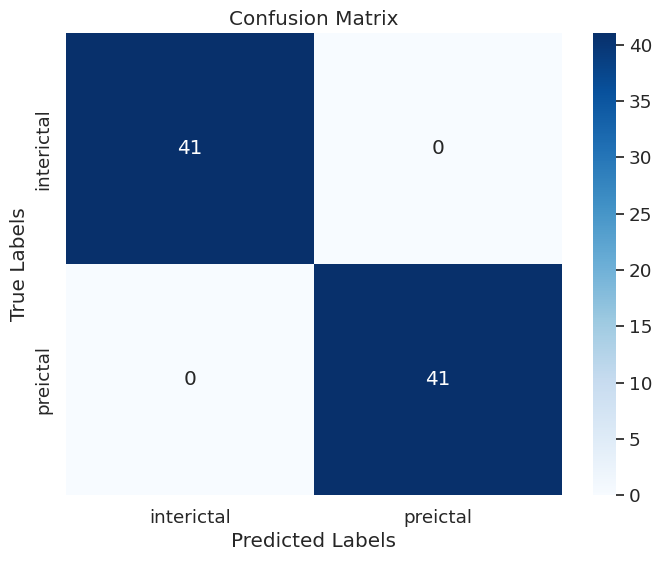

1.0 1.0 1.0 41 41 0 0


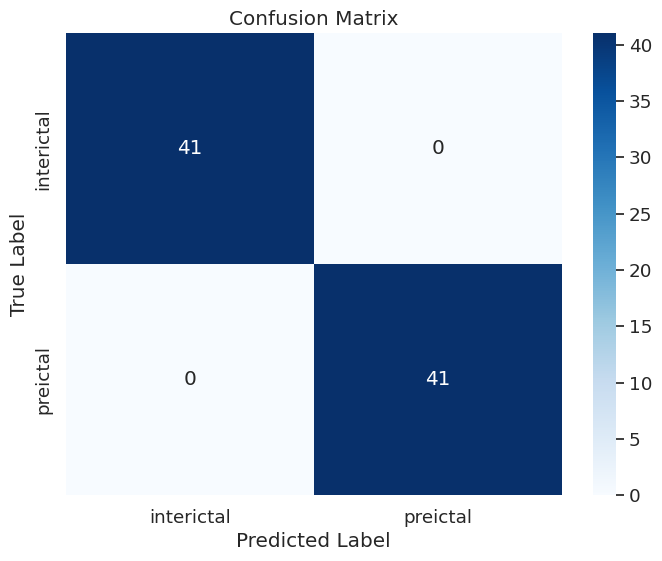

Accuracy:  1.0  Recall:  1.0  Precision:  1.0  True Positives:  41  True Negatives:  41  False Positives:  0  False negatives:  0
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
39 177
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
39 177
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
39 177
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
39 177
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
39 177
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
39 177
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
39 177
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
39 177
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
39 177
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
39 177
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━

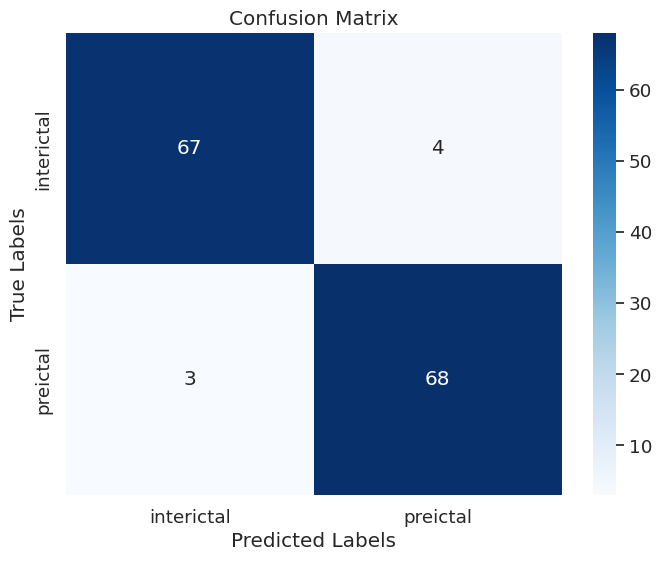

0.9507042253521126 0.9577464788732394 0.9444444444444444 68 67 4 3


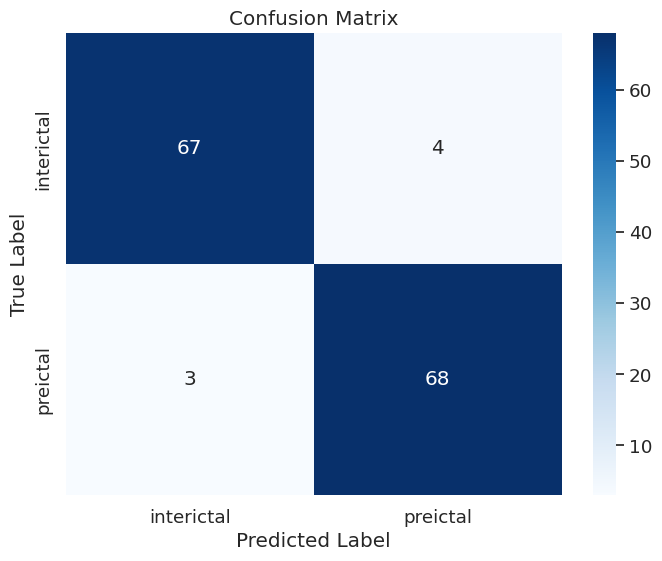

Accuracy:  0.9507042253521126  Recall:  0.9577464788732394  Precision:  0.9444444444444444  True Positives:  68  True Negatives:  67  False Positives:  4  False negatives:  3
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
39 177
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
39 177
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
39 177
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
39 177
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
39 177
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
39 177
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
39 177
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
39 177
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
39 177
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
39 177
1/1 ━━━━━━━━━━━

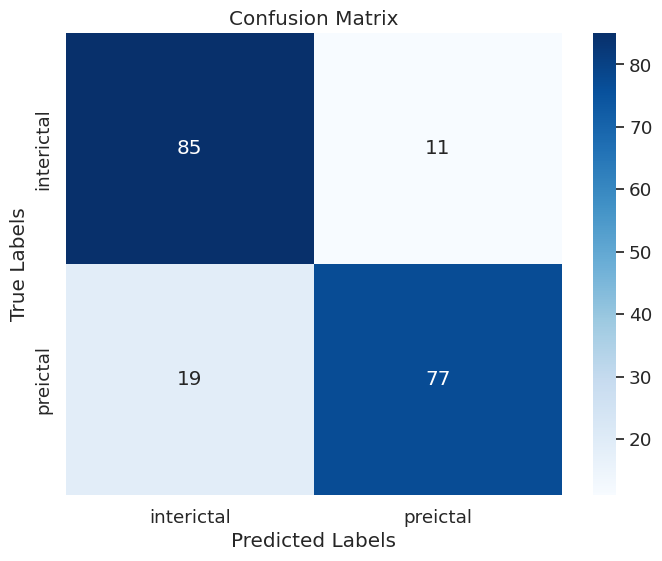

0.84375 0.8020833333333334 0.875 77 85 11 19


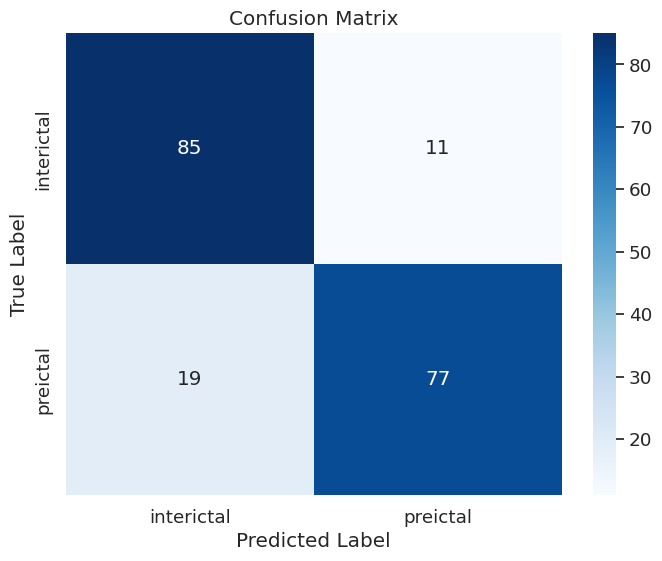

Accuracy:  0.84375  Recall:  0.8020833333333334  Precision:  0.875  True Positives:  77  True Negatives:  85  False Positives:  11  False negatives:  19


In [129]:
hybrid_model = load_model('/kaggle/working/new_sxx_lstm_hybrid_model_fully_trained.h5')
# hybrid_model = model
dog_segments = [42, 72, 97]

for i in range(len(dog_segments)):

    interictal_x , preictal_x = evaluate_hybrid_model(hybrid_model, dog_segments[i],'preictal', i + 2)
    print("Given all preictal: ", "interictal predicted: ", interictal_x, "preictal predicted: ", preictal_x)

    true_labels_x = np.ones(dog_segments[i] - 1)
    predicted_labels_x = np.concatenate((np.zeros(interictal_x), np.ones(preictal_x)))

    interictal_y , preictal_y = evaluate_hybrid_model(hybrid_model, dog_segments[i],'interictal', i + 2)
    print("Given all interictal: ", "interictal predicted: ", interictal_y, "preictal predicted: ", preictal_y)

    true_labels_y =  np.zeros(dog_segments[i] - 1)
    predicted_labels_y = np.concatenate((np.zeros(interictal_y), np.ones(preictal_y)))

    create_confusion_matrix(interictal_x,preictal_x,interictal_y,preictal_y)

    true_labels = np.concatenate((true_labels_x, true_labels_y))
    predicted_labels = np.concatenate((predicted_labels_x,predicted_labels_y))

    calculate_metrics(true_labels, predicted_labels)